# Project SE511: Road Vector Layer

The goal of this project is to automatically generate a GIS vector layer of roads, based on Sentinel-1 and Sentinel-2 data. For the development of the aqlgorithm, an area-of-interest between (4.4480, 50.7946) and (4.4840, 50.8200) is considered. Later, the algorithm is validated on another area.

## 0. Importing required packages and modules

In [1]:
from terracatalogueclient import Catalogue
import datetime as dt
import rasterio
import rasterio.mask as msk
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
import numpy as np
from shapely.geometry import Polygon, box, mapping

from catalogclient import catalog

from skimage import exposure, measure, data, color, morphology, filters, io
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask, gaussian, meijering, sato, frangi, hessian
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.feature import canny

import math
import cv2 as cv

## 1. Retrieving the Sentinel-1 and Sentinel-2 data for the considered Area-of-Interest

First, we need to extract both the Sentinel-1 (S1) and the Sentinel-2 (S2) image of the area of interest. Moreover, both images should be close in time and the S2 image should contain as few clouds as possible. In order to do this, we first create a list of all collections belonging to both the Sentinel-1 and the Sentinel-2 platform. Since we need high resolution images to accurately detect roads, only the images with a resolution of 10m will be considered.

In [2]:
catalogue = Catalogue()

### 1.1 Sentinel-1 images

For the Sentinel-1 platform, we will consider the `GRD_SIGMA0` products. We now need to know from which data we want to extract the image. As said before, the Sentinel-2 image should contain as few clouds as possible, and both the Sentinel-1 and the Sentinel-2 image should be close together in time (within a few days). In order to determine a suitable date, we used the following URL : https://viewer.terrascope.be/?language=nl&bbox=2.106090632973768,50.513846960679246,5.035320369301893,51.41418101205741&overlay=false&bgLayer=MapBox&date=2019-02-25T03:17:15.000Z&layer=CGS_S2_RADIOMETRY . 

This tool allows to select an area of interest and a limit to the amount of clouds. By setting the cloud limit to 10% and entering the area of interest, we get a list of all suitbale dates. After some retries, we found that **July 31, 2020** is a suitbale date for which both S1 and S2 imagery exists for our area-of-interest.


In [3]:
start_date = dt.date(2020,7,31)
end_date = dt.date(2020,8,1)
products_S1 = list(catalogue.get_products('urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1',start_date,end_date))
for product in products_S1:
    print(product.title,", coverage area:",product.bbox)

S1A_IW_GRDH_SIGMA0_DV_20200731T033327_DESCENDING_21_64B2_V110 , coverage area: [36.342323, 40.043488, 39.779671, 41.944347]
S1A_IW_GRDH_SIGMA0_DV_20200731T051056_DESCENDING_22_0B3D_V110 , coverage area: [12.58525, 44.570213, 16.312489, 46.475739]
S1A_IW_GRDH_SIGMA0_DV_20200731T051121_DESCENDING_22_F7D2_V110 , coverage area: [12.272643, 43.069172, 15.885759, 44.977924]
S1A_IW_GRDH_SIGMA0_DV_20200731T051146_DESCENDING_22_2E1C_V110 , coverage area: [11.939182, 41.570995, 15.4899, 43.477352]
S1A_IW_GRDH_SIGMA0_DV_20200731T084336_DESCENDING_24_7848_V110 , coverage area: [-47.886967, -10.409199, -45.259216, -8.385692]
S1A_IW_GRDH_SIGMA0_DV_20200731T084401_DESCENDING_24_7B48_V110 , coverage area: [-48.240658, -11.917842, -45.59898, -9.888956]
S1A_IW_GRDH_SIGMA0_DV_20200731T160143_ASCENDING_28_F82A_V110 , coverage area: [34.682053, -12.570012, 37.367088, -10.29866]
S1A_IW_GRDH_SIGMA0_DV_20200731T175625_ASCENDING_30_319E_V110 , coverage area: [-2.809776, 45.200817, 0.90802, 47.101959]
S1A_IW_GR

Next, we need to find the image(s) that contain our defined area-of-interest (AOI). This can be easily done by defining a polygon and checking in which image this polygon can be found.

The considered area-of-interest is the region between **(4.4480, 50.7946) and (4.4840, 50.8200)**.

In [4]:
AOI = box(4.448, 50.7946, 4.484, 50.82)

for idx, product in enumerate(products_S1):
    if AOI.within(box(*product.bbox)):
        print(idx, product.title)
        idx_S1 = idx

9 S1B_IW_GRDH_SIGMA0_DV_20200731T055800_DESCENDING_110_5F52_V110


Finally, we obtain 1 Sentinel-1 image, made on July 31, 2020, that covers our area-of interest. From the title of the image, we can see that the image was made on July 31, 2020, at 05:58:00, which is according to our requirement. Also, we can see that the Sentinel-1 satellite was in the descending part of orbit number 110.

In [5]:
image_S1 = products_S1[idx_S1]

### 1.2 Sentinel-2 images

The same procedure is now used to find the corresponding **Sentinel-2 image**. We will look for images with a high spatial resolution (10 m; this will be the R, G, B and NIR-bands), made on July 31, 2020 and that contain our defined area-of-interest.

In [6]:
# Define catalogue
cat = catalog.Catalog()

To find the corresponding image, we need to supply some parameters to the `get_products` command. The required fields are listed below:

In [7]:
cat.get_products?

Signature:
cat.get_products(
    producttype,
    fileformat='HDF5',
    startdate=None,
    enddate=None,
    min_lon=-180,
    max_lon=180,
    min_lat=-90,
    max_lat=90,
)
Docstring:
Returns EOProducts for specified product type, file format, region of interest
and date range.
File:      /usr/local/lib/python3.6/site-packages/catalogclient/catalog.py
Type:      method


These fields can be filled as follows:
* `producttype` is the virtual catalogue corresponding to the desired resolution; 10 m in our case.
* `startdata` and `enddate` refer to our selected date of July 31, 2020.
* `fileformat` is `GEOTIFF`, in correspondance with the Sentinel-1 image.

These parameters are configured below:

In [8]:
producttype = 'CGS_S2_RADIOMETRY_10M'
fileformat = 'GEOTIFF'
start = start_date # same date as Sentinel-1 image
end = end_date

coord = mapping(AOI)['coordinates'][0]
minLat = coord[3][1]
maxLat = coord[1][1]
minLon = coord[3][0]
maxLon = coord[1][0]

products_S2 = cat.get_products(
    producttype,
    fileformat,
    start,
    end,
    minLon,
    maxLon,
    minLat,
    maxLat,
)

In [9]:
print(f'{len(products_S2)} products of type {producttype} found')

3 products of type CGS_S2_RADIOMETRY_10M found


As there is more than 1 suitable image, we will now compare the timsestamps in order to find the image closest in time to the Sentinel-1 image.

In [10]:
for counter, img in enumerate(products_S2):
    print(f'Timestamp of image [{counter}]:',img._timestamp)

Timestamp of image [0]: 2020-08-01 11:02:47
Timestamp of image [1]: 2020-07-31 10:46:07
Timestamp of image [2]: 2020-07-31 10:46:07


It is clear that only the last 2 images are made on July 31, 2020. We select the second image for the remainder of this project.

In [11]:
image_S2 = products_S2[1] #takes the first image available
bands = image_S2.bands()
for b in bands:
    print('Available band: {}'.format(b))

Available band: SHADOWMASK
Available band: B02
Available band: B04
Available band: B03
Available band: B08
Available band: CLOUDMASK


We see that all 4 high-resolution bands are present, as well as the cloudmask and the shadowmask. This image is thus suitable for our analysis.

 ### 1.3 Representation of the images

#### 1.3.0 Supporting functions

In [12]:
def get_filename(item):
    # obtain filename by replacing "https://services.terrascope.be/download/" with "/data/MTDA/CGS_S1/"
    _, tail = item.href.split('download/')
    return '/data/MTDA/CGS_S1/' + tail

def image_specs(image,index):
    filename = get_filename(image.data[index]) 
    with rasterio.open(filename) as src:
        width = src.width
        res = src.res
        left,bottom,right,top = src.bounds[0:4]
        crs = src.crs

        print(f"Size of the image: width = {width}")
        print(f"The spatial resoltion is {res}")
        print("This image covers a rectangular area between (in meters):")
        print(f"\t * top left corner     = [left  = {left}, top    = {top}]")
        print(f"\t * bottom right corner = [right = {right}, bottom = {bottom}]")
        print("These are coordinates relative to the origin the coordinate reference system (crs).")
        print(f"For these images, the crs is {crs}")
        
def extract_aoi(aoi, files):
    images = {}
    for key, filename in files.items():
        with rasterio.open(filename) as src:
            out_image, out_transform = msk.mask(src, [aoi], crop=True, all_touched = True)
            images[key] = out_image[0, :, :]
            if key == 'angle': # additional processing (scaling) for incidence images, see ATBD
                images[key] = images[key] * 0.0005 + 29      
    return images

def plot_bands(aoi):
    fig, ax = plt.subplots(1,2,figsize=(8,8))
    idx_plot = -1
    for idx, (key, image) in enumerate(aoi.items()):
        if key != 'angle':
            idx_plot += 1
            #ax[idx].imshow(exposure.equalize_hist(image), cmap='gray')
            ax[idx_plot].imshow(10*np.log10(image), cmap='gray')
            ax[idx_plot].set_title(key)
        
def equalized_image(image,AOI):
    return exposure.equalize_hist(msk.mask(
        rasterio.open(image),
        [AOI],
        all_touched=False,
        invert=False,
        nodata=None,
        filled=True,
        crop=True,
        pad=False,
        indexes=None,
    )[0][0])

#### 1.3.1 Representation of the Sentinel-1 image

Before we can represent an image, we need to know some of its specifications, like the image boundaries and the used Coordinate Reference System (CRS). This information can be obtained by using the `image_specs` function, defined as supporting function above.

In [13]:
image_specs(image_S1,0)

Size of the image: width = 29864
The spatial resoltion is (10.0, 10.0)
This image covers a rectangular area between (in meters):
	 * top left corner     = [left  = 398513.81756164413, top    = 5792455.353976404]
	 * bottom right corner = [right = 697153.8175616441, bottom = 5576595.353976404]
These are coordinates relative to the origin the coordinate reference system (crs).
For these images, the crs is EPSG:32631


Before we can represent the images, we need to transfrom the AOI-coordinates to EPSG:32631 WGS 84 / UTM zone 31N coordinates. This is done by using an online converter. (https://epsg.io/transform#s_srs=4326&t_srs=32631&x=NaN&y=NaN)

In [14]:
minLon_31N = 602051.3564568218
minLat_31N = 5627983.377252568
maxlon_31N = 604531.7261052807
maxLat_31N = 5630857.98221463

AOI_31N = Polygon([(minLon_31N, maxLat_31N),
               (minLon_31N, minLat_31N),
               (maxlon_31N, minLat_31N),
               (maxlon_31N, maxLat_31N)])

As a last step before we can create the images, we have to create a dictionary that contains the title and the filename for the different elements of our Sentintel-1 image.

In [15]:
files = dict([(item.title, get_filename(item)) for item in image_S1.data])
images_aoi = extract_aoi(AOI_31N, files)

The 2 useful bands of the Sentinel-1 image(Vertical-Horizontal and Vertical-Vertical) in our defined area-of-interest are plotted below. One can immediately recognize the presence of 2 sets of crossing roads and a curved road in the top right corner of the images.

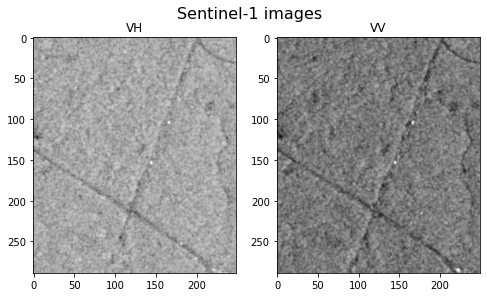

In [16]:
plot_bands(images_aoi) #VV: vertical-vertical / VH: Vertical-Horizontal polarization modes
plt.figtext(0.5, 0.74, 'Sentinel-1 images', ha='center',fontsize = 16)
plt.show()

#### 1.3.2 Representation of the Sentinel-2 images

In [17]:
for counter, value in enumerate(bands):
    if value == 'B02':
        B_index = counter # Blue component of visible image
    elif value == 'B03':
        G_index = counter # Green component of visible image
    elif value == 'B04':
        R_index = counter # Red component of visible image
    elif value == 'B08': 
        NIR_index = counter
    elif value == 'CLOUDMASK': 
        CL_index = counter
    elif value == 'SHADOWMASK': 
        SH_index = counter
imagename_B = str(image_S2.files[B_index])[5:]
imagename_G = str(image_S2.files[G_index])[5:]
imagename_R = str(image_S2.files[R_index])[5:]
imagename_NIR = str(image_S2.files[NIR_index])[5:]
imagename_CL = str(image_S2.files[CL_index])[5:]
imagename_SH = str(image_S2.files[SH_index])[5:]

We again need to verify which coordinate system is used for these Sentinel-2 images.

In [18]:
print("Coordinate reference system: ",rasterio.open(imagename_B).crs)

Coordinate reference system:  EPSG:32631


The same reference system as for the Sentinel-1 image is used, so we can simply reuse the `AOI_31N`.

Now the images will be plotted. The R, G and B images are equalized to improve the contrast. Furthermore, they are stacked to represent 1 colored image.

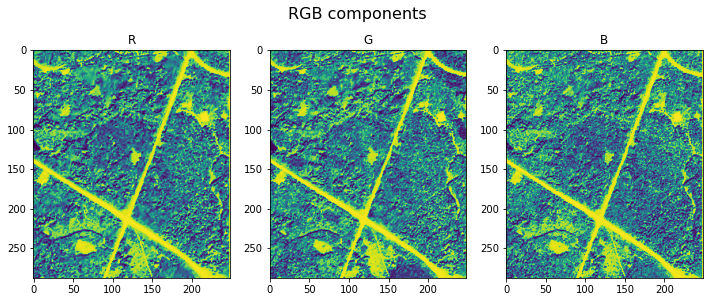

In [19]:
equalized_image_R = equalized_image(imagename_R,AOI_31N)
equalized_image_G = equalized_image(imagename_G,AOI_31N)
equalized_image_B = equalized_image(imagename_B,AOI_31N)

fig, ax = plt.subplots(1, 3,figsize=(12,12))
ax[0].imshow(equalized_image_R)
ax[0].set_title('R')
ax[1].imshow(equalized_image_G)
ax[1].set_title('G')
ax[2].imshow(equalized_image_B)
ax[2].set_title('B')
plt.figtext(0.5, 0.67, 'RGB components', ha='center',fontsize = 16)
plt.show()

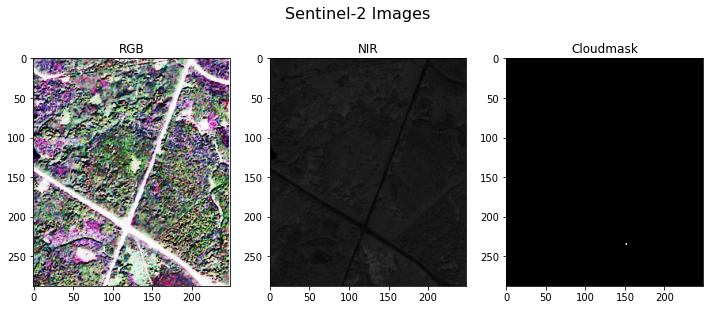

In [23]:
img_RGB = np.dstack((equalized_image_R, equalized_image_G, equalized_image_B))
img_NIR = msk.mask(
    rasterio.open(imagename_NIR),
    [AOI_31N],
    all_touched=False,
    invert=False,
    nodata=None,
    filled=True,
    crop=True,
    pad=False,
    indexes=None,
)[0][0]
img_CL = msk.mask(
    rasterio.open(imagename_CL),
    [AOI_31N],
    all_touched=False,
    invert=False,
    nodata=None,
    filled=True,
    crop=True,
    pad=False,
    indexes=None,
)[0][0]

fig, ax = plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(img_RGB)
ax[0].set_title('RGB')
ax[1].imshow(img_NIR, cmap=plt.cm.gray)
ax[1].set_title('NIR')
ax[2].imshow(img_CL, cmap=plt.cm.gray)
ax[2].set_title('Cloudmask')
plt.figtext(0.5, 0.68, 'Sentinel-2 Images', ha='center',fontsize = 16)
plt.show()

We can see that the NIR image appears very dark. Hence, it does not reveal a lot of information to the human observer. In order to resolve this issue, white top-hat filtering will be applied to this image.

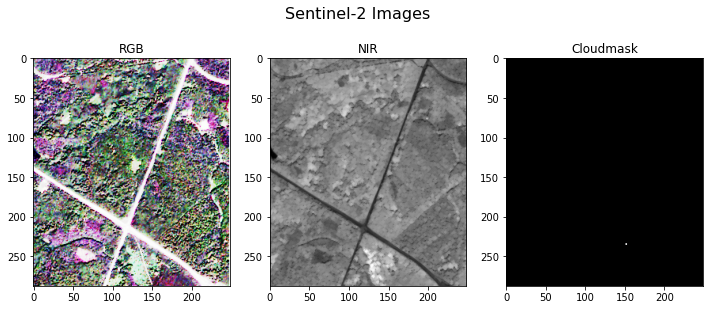

In [25]:
image = img_NIR
footprint = morphology.disk(1)
res = morphology.white_tophat(image, footprint)
flt_img_NIR = image - res

fig, ax = plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(img_RGB)
ax[0].set_title('RGB')
ax[1].imshow(flt_img_NIR, cmap=plt.cm.gray)
ax[1].set_title('NIR')
ax[2].imshow(img_CL, cmap=plt.cm.gray)
ax[2].set_title('Cloudmask')
plt.figtext(0.5, 0.68, 'Sentinel-2 Images', ha='center',fontsize = 16)
plt.show()

## 2. Extract the pixels that most likely belong to the class "road" to create a ground truth

Before applying the algorithms, we will enhance the images and extract a ground truth. This will be done in section 2.1.

### 2.1 Image Enhancement

#### 2.1.1 Removing small objects

https://scikit-image.org/docs/dev/auto_examples/filters/plot_tophat.html#sphx-glr-auto-examples-filters-plot-tophat-py

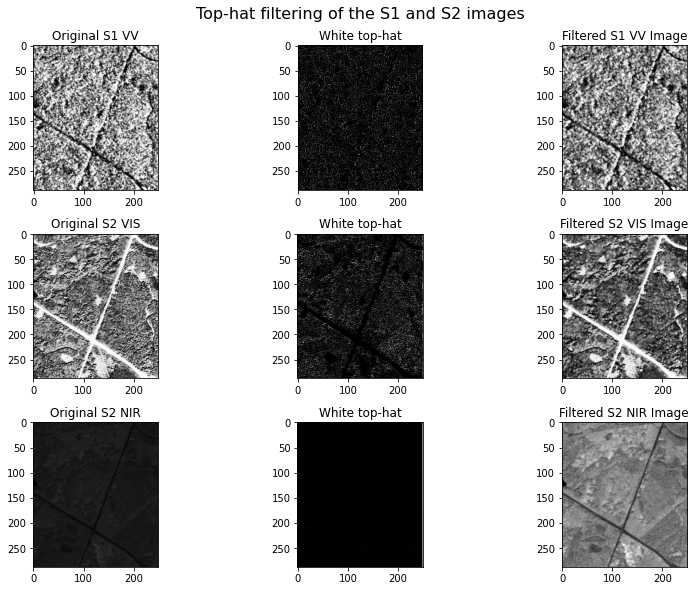

In [26]:
radius = 1

image1 = exposure.equalize_hist(images_aoi['VV'])
footprint1 = morphology.disk(radius)
res1 = morphology.white_tophat(image1, footprint1)
filtered_image_S1 = image1 - res1

image2 = rgb2gray(img_RGB)
footprint2 = morphology.disk(radius)
res2 = morphology.white_tophat(image2, footprint2)
filtered_image_S2 = image2 - res2

image3 = img_NIR
footprint3 = morphology.disk(radius)
res3 = morphology.white_tophat(image3, footprint3)
filtered_image_S2_NIR = image3 - res3


fig, ax = plt.subplots(3,3, figsize=(12, 8))

ax[0,0].set_title('Original S1 VV')
ax[0,0].imshow(image1, cmap='gray')
ax[0,1].set_title('White top-hat')
ax[0,1].imshow(res1, cmap='gray')
ax[0,2].set_title('Filtered S1 VV Image')
ax[0,2].imshow(filtered_image_S1, cmap='gray')

ax[1,0].set_title('Original S2 VIS')
ax[1,0].imshow(image2, cmap='gray')
ax[1,1].set_title('White top-hat')
ax[1,1].imshow(res2, cmap='gray')
ax[1,2].set_title('Filtered S2 VIS Image')
ax[1,2].imshow(filtered_image_S2, cmap='gray')

ax[2,0].set_title('Original S2 NIR')
ax[2,0].imshow(image3, cmap='gray')
ax[2,1].set_title('White top-hat')
ax[2,1].imshow(res3, cmap='gray')
ax[2,2].set_title('Filtered S2 NIR Image')
ax[2,2].imshow(filtered_image_S2_NIR, cmap='gray')

plt.figtext(0.5, 1, 'Top-hat filtering of the S1 and S2 images', ha='center',fontsize = 16)
plt.savefig('Images/Image Enhancement/tophat.png')
fig.tight_layout()
plt.show()

#### 2.1.2 Unsharp masking

https://scikit-image.org/docs/dev/auto_examples/filters/plot_unsharp_mask.html#sphx-glr-auto-examples-filters-plot-unsharp-mask-py

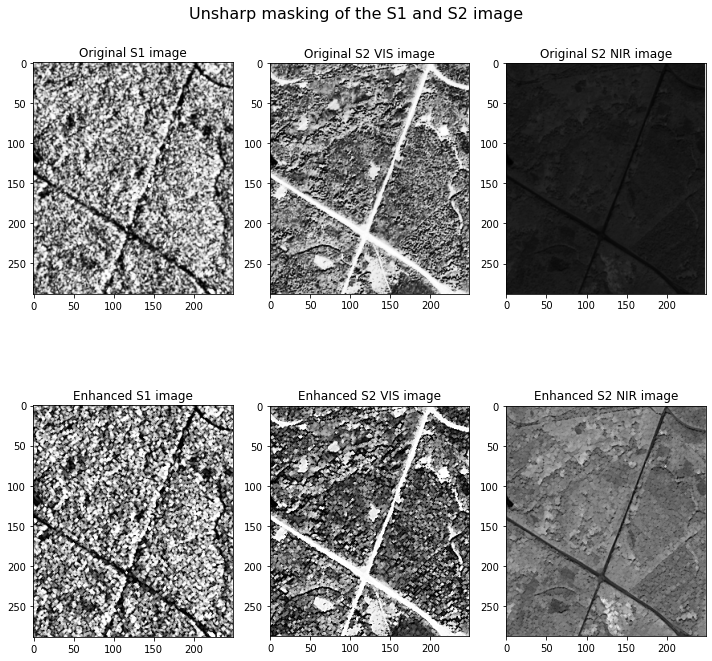

In [27]:
radius = 1
amplification = 1.5
image1 = filtered_image_S1
image2 = filtered_image_S2
image3 = filtered_image_S2_NIR
masked_S1 = unsharp_mask(image1, radius, amplification)
masked_S2 = unsharp_mask(image2, radius, amplification)
masked_S2_NIR = unsharp_mask(image3, radius, amplification)

fig, ax = plt.subplots(2,3, figsize=(10, 10))

ax[0,0].imshow(exposure.equalize_hist(images_aoi['VV']), cmap=plt.cm.gray)
ax[0,0].set_title('Original S1 image')
ax[1,0].imshow(masked_S1, cmap=plt.cm.gray)
ax[1,0].set_title('Enhanced S1 image')
ax[0,1].imshow(rgb2gray(img_RGB), cmap=plt.cm.gray)
ax[0,1].set_title('Original S2 VIS image')
ax[1,1].imshow(masked_S2, cmap=plt.cm.gray)
ax[1,1].set_title('Enhanced S2 VIS image')
ax[0,2].imshow(img_NIR, cmap=plt.cm.gray)
ax[0,2].set_title('Original S2 NIR image')
ax[1,2].imshow(masked_S2_NIR, cmap=plt.cm.gray)
ax[1,2].set_title('Enhanced S2 NIR image')

plt.figtext(0.5, 0.96, 'Unsharp masking of the S1 and S2 image', ha='center',fontsize = 16)

fig.tight_layout()
plt.show()

### 2.2 Creating a histogram of the (enhanced) images

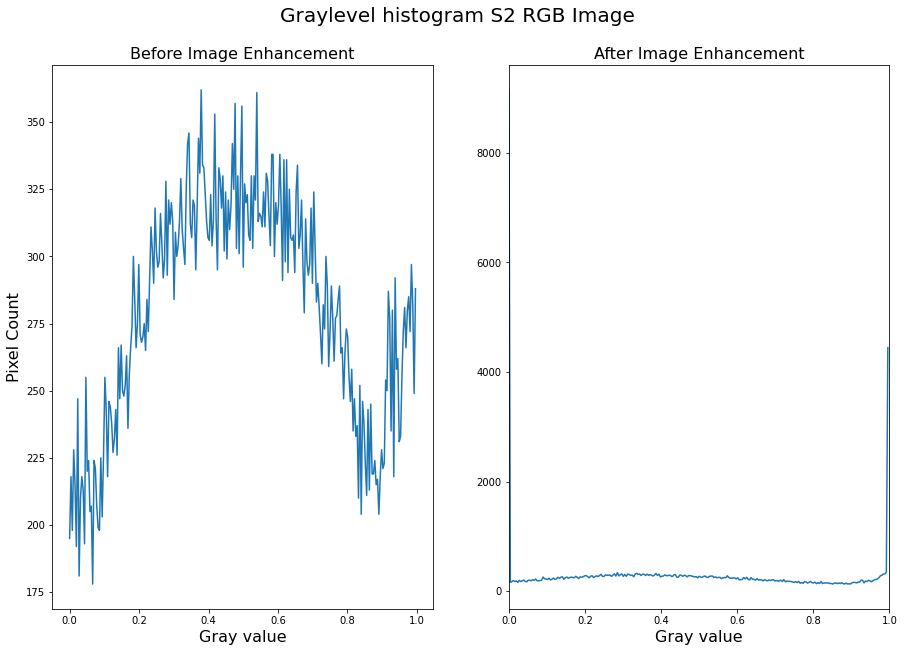

In [28]:
gray_image1 = rgb2gray(img_RGB)
gray_image2 = masked_S2
histogram1, bin_edges1 = np.histogram(gray_image1, bins=256, range=(0.0, 1.0))
histogram2, bin_edges2 = np.histogram(gray_image2, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots(1,2,figsize=(15,10))
ax[0].plot(bin_edges1[0:-1], histogram1)
ax[0].set_title('Before Image Enhancement', fontsize=16)
ax[0].set_xlabel("Gray value", fontsize=16), ax[0].set_ylabel("Pixel Count", fontsize=16)

ax[1].plot(bin_edges2[0:-1], histogram2)
ax[1].set_title('After Image Enhancement', fontsize=16)
ax[1].set_xlabel("Gray value", fontsize=16), ax[0].set_ylabel("Pixel Count", fontsize=16)
plt.xlim(0, 1.0)
plt.figtext(0.5, 0.94, "Graylevel histogram S2 RGB Image", ha='center',fontsize = 20)
plt.show()

### 2.3 Ground Truth Extraction

Now, a ground truth will be extrcated from the S2 RGB image in order to have a reference to assess the performance of the road detection algorithm.

In [29]:
def groundtruthgenerator(image, tol):
    ground_truth = image > tol # set all pixels with value above tol to 1, all other pixels are set to 0
    ground_truth[:,image.shape[1]-1] = 0
    return ground_truth

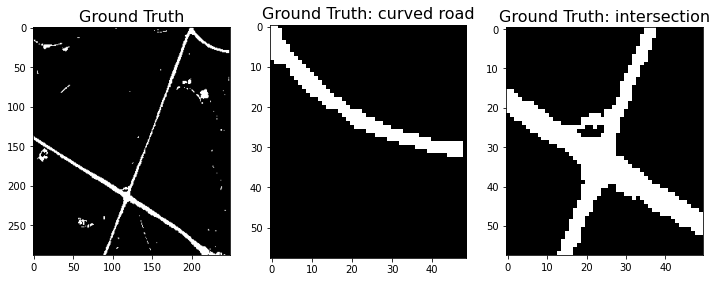

In [30]:
ground_truth = groundtruthgenerator(rgb2gray(img_RGB),0.95) # create binary mask
ground_truth_extract_curve = ground_truth[0:58,200:250]
ground_truth_extract_intersect = ground_truth[180:238, 95:145]

fig, ax = plt.subplots(1, 3,figsize=(12,12))

ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth',fontsize=16)

ax[1].imshow(ground_truth_extract_curve, cmap='gray')
ax[1].set_title('Ground Truth: curved road',fontsize=16)

ax[2].imshow(ground_truth_extract_intersect, cmap='gray')
ax[2].set_title('Ground Truth: intersection',fontsize=16)


plt.savefig('Images/Ground_truth/ground_truth.png')

## 3. Exploit a number of detection algorithms form the scikit-image library

In this section, we will use some of the detection algorithms from the *scikit-image* library to automatically detect the roads in an image. These will then be compared to the ground truth, which we established in the previous section.

### 3.0 Supporting functions

In [31]:
def rotate(vector, theta, rotation_around=None) -> np.ndarray:
    """
    reference: https://en.wikipedia.org/wiki/Rotation_matrix#In_two_dimensions
    :param vector: list of length 2 OR
                   list of list where inner list has size 2 OR
                   1D numpy array of length 2 OR
                   2D numpy array of size (number of points, 2)
    :param theta: rotation angle in degree (+ve value of anti-clockwise rotation)
    :param rotation_around: "vector" will be rotated around this point, 
                    otherwise [0, 0] will be considered as rotation axis
    :return: rotated "vector" about "theta" degree around rotation
             axis "rotation_around" numpy array
    """
    vector = np.array(vector)

    if vector.ndim == 1:
        vector = vector[np.newaxis, :]

    if rotation_around is not None:
        vector = vector - rotation_around

    vector = vector.T

    theta = np.radians(theta)

    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    output: np.ndarray = (rotation_matrix @ vector).T

    if rotation_around is not None:
        output = output + rotation_around

    return output.squeeze()

def loopdetection(contours, tolerance, limit):
    ind_no_loops = []
    for ind in range(0,len(contours)):
        if abs(contours[ind][:,1][0] - contours[ind][:,1][-1]) > tolerance or abs(contours[ind][:,0][0] - contours[ind][:,0][-1]) > tolerance: # the detected contour is not a loop
            ind_no_loops.append(ind)
        else:
            theta = np.degrees(np.arctan((np.max(contours[ind][:,0]) - np.min(contours[ind][:,0]))/(np.max(contours[ind][:,1]) - np.min(contours[ind][:,1]))))
            rotated = rotate(contours[ind], -theta, rotation_around=None) 
            if (np.max(rotated[:,1])-np.min(rotated[:,1]))/(np.max(rotated[:,0])-np.min(rotated[:,0])) > limit or (np.max(rotated[:,1])-np.min(rotated[:,1]))/(np.max(rotated[:,0])-np.min(rotated[:,0])) < 1/limit:
                if np.max(rotated[:,1])-np.min(rotated[:,1]) > limit and np.max(rotated[:,0])-np.min(rotated[:,0]) > limit: 
                    ind_no_loops.append(ind) #very narrow loops (ratio radii at least equal to limit) will be considered as a path         
    no_loops = []
    for ind in ind_no_loops:
        no_loops.append(contours[ind])
    return no_loops

### 3.1 Contour Finding

First, we will use the contour finding algorithm in an attempt to automate the extraction of roads from the Sentinel images. 

#### Contour Finding for the Sentinel-2 Image

On the plot below, this algorithm is applied to the Sentinel-2 RGB image. A loop is created to automatically try several constant values.

In [32]:
image = filtered_image_S2

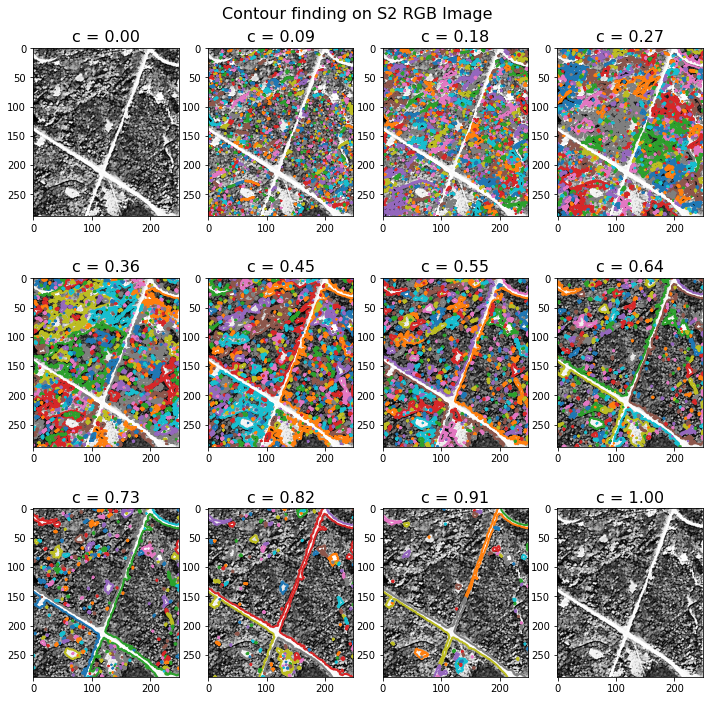

In [33]:
vec = np.linspace(0,1,num=12)
fig, axes = plt.subplots(3,4,figsize=(12,12))
ax = axes.ravel()
ind = -1
for cval in vec:
    ind += 1
    contours = measure.find_contours(image, cval)
    ax[ind].imshow(masked_S2, cmap='gray')
    for contour in contours:
        ax[ind].plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax[ind].set_title('c = {:.2f}'.format(cval), ha='center',fontsize = 16)

plt.figtext(0.5, 0.90, 'Contour finding on S2 RGB Image', ha='center',fontsize = 16)
plt.show()

A value of c = 0.90 is retained for the remainder of the analysis.

In [34]:
cval = 0.90
contours = measure.find_contours(image, cval)

#### 3.1.1 Loop detection

We can see that the roads are indeed detected quite well, but there are still a lot of falsely detected pixels. In a first attempt to clean up these results, we will try to get rid of the small closed loops, since these obviously cannot represent roads. This is done for several threshold values.

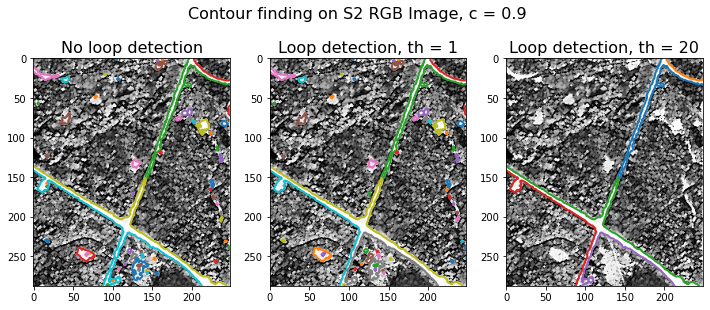

In [35]:
lim1, lim2 = 1, 20

no_loops1 = loopdetection(contours,15,lim1)
no_loops2 = loopdetection(contours,15,lim2)
fig, ax = plt.subplots(1,3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Contour finding on S2 RGB Image, c = {}'.format(cval), ha='center',fontsize = 16)

ax[0].imshow(masked_S2, cmap=plt.cm.gray)
ax[1].imshow(masked_S2, cmap=plt.cm.gray)
ax[2].imshow(masked_S2, cmap=plt.cm.gray)

ax[0].set_title('No loop detection', ha='center',fontsize = 16)
ax[1].set_title('Loop detection, th = {}'.format(lim1), ha='center',fontsize = 16)
ax[2].set_title('Loop detection, th = {}'.format(lim2), ha='center',fontsize = 16)

for contour in contours:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2)
    
for contour in no_loops1:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

for contour in no_loops2:
    ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)

#### Sentinel-2 NIR Image

The same procedure will now be applied to the Sentintel-2 NIR image.

In [36]:
image = masked_S2_NIR

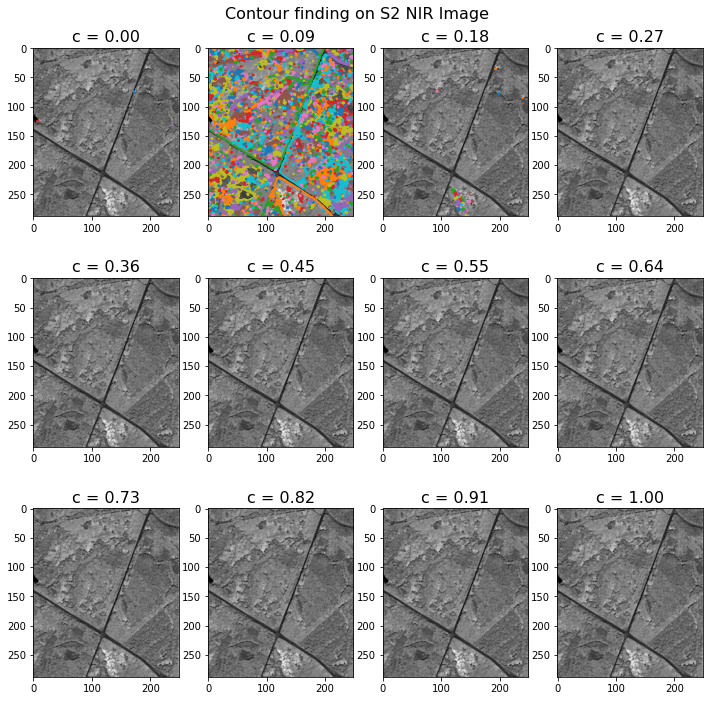

In [37]:
vec = np.linspace(0,1,num=12)
fig, axes = plt.subplots(3,4,figsize=(12,12))
ax = axes.ravel()
ind = -1
for cval in vec:
    ind += 1
    contours = measure.find_contours(image , cval)
    ax[ind].imshow(masked_S2_NIR, cmap='gray')
    for contour in contours:
        ax[ind].plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax[ind].set_title('c = {:.2f}'.format(cval), ha='center',fontsize = 16)

plt.figtext(0.5, 0.90, 'Contour finding on S2 NIR Image', ha='center',fontsize = 16)
plt.show()

A value of c = 0.07 is retained for the remainder of the analysis.

In [38]:
cval_NIR = 0.07
contours_NIR = measure.find_contours(image , cval_NIR)

Again, the loop detection algorithm is applied to the S2 NIR image.

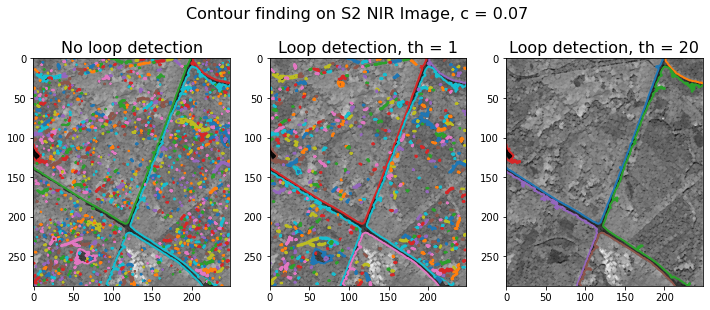

In [39]:
lim1, lim2 = 1, 20

no_loops_NIR1 = loopdetection(contours_NIR,15,lim1)
no_loops_NIR2 = loopdetection(contours_NIR,15,lim2)

fig, ax = plt.subplots(1,3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Contour finding on S2 NIR Image, c = {}'.format(cval_NIR), ha='center',fontsize = 16)

ax[0].imshow(masked_S2_NIR, cmap=plt.cm.gray)
ax[1].imshow(masked_S2_NIR, cmap=plt.cm.gray)
ax[2].imshow(masked_S2_NIR, cmap=plt.cm.gray)

ax[0].set_title('No loop detection', ha='center',fontsize = 16)
ax[1].set_title('Loop detection, th = {}'.format(lim1), ha='center',fontsize = 16)
ax[2].set_title('Loop detection, th = {}'.format(lim2), ha='center',fontsize = 16)

for contour in contours_NIR:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2)
    
for contour in no_loops_NIR1:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

for contour in no_loops_NIR2:
    ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)

#### Sentinel-1 Image

The same procedure will now be applied to the Sentintel-1 image.

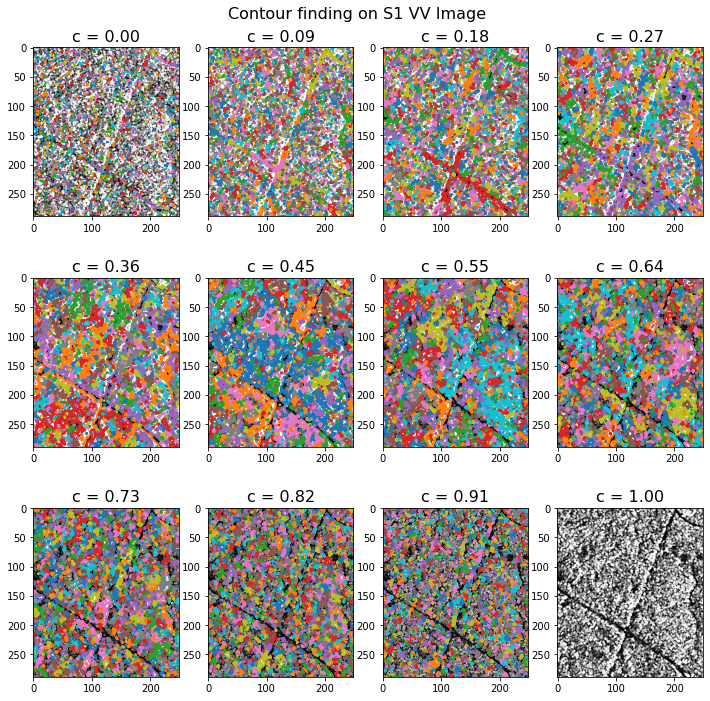

In [40]:
vec = np.linspace(0,1,num=12)
fig, axes = plt.subplots(3,4,figsize=(12,12))
ax = axes.ravel()
ind = -1
for cval in vec:
    ind += 1
    contours = measure.find_contours(masked_S1, cval)
    ax[ind].imshow(masked_S1, cmap='gray')
    for contour in contours:
        ax[ind].plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax[ind].set_title('c = {:.2f}'.format(cval), ha='center',fontsize = 16)

plt.figtext(0.5, 0.90, 'Contour finding on S1 VV Image', ha='center',fontsize = 16)
plt.show()

A value of c = 0.21 is retained for the remainder of the analysis.

In [41]:
cval_S1 = 0.21
contours_VV = measure.find_contours(masked_S1, cval_S1)

The results after applying the loop detection algorithm are shown below.

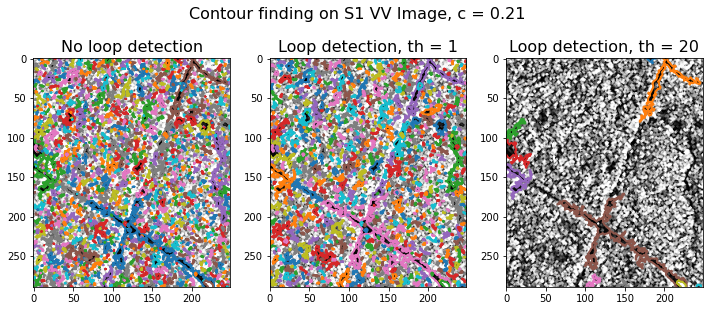

In [42]:
lim1, lim2 = 1, 20

no_loops_S1_1 = loopdetection(contours_VV,5,lim1)
no_loops_S1_2 = loopdetection(contours_VV,5,lim2)
fig, ax = plt.subplots(1,3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Contour finding on S1 VV Image, c = {}'.format(cval_S1), ha='center',fontsize = 16)

ax[0].imshow(masked_S1, cmap=plt.cm.gray)
ax[1].imshow(masked_S1, cmap=plt.cm.gray)
ax[2].imshow(masked_S1, cmap=plt.cm.gray)

ax[0].set_title('No loop detection', ha='center',fontsize = 16)
ax[1].set_title('Loop detection, th = {}'.format(lim1), ha='center',fontsize = 16)
ax[2].set_title('Loop detection, th = {}'.format(lim2), ha='center',fontsize = 16)

for contour in contours_VV:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2)
    
for contour in no_loops_S1_1:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

for contour in no_loops_S1_2:
    ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)

We can see that the roads are now not very well detected. In conclusion, this method only works well for Sentinel-2 images.

### 3.1.2 Comparing the algorithm with the ground truth

Finally, the results of the algorithm (only for the S2 images) will be compared with the ground truth.

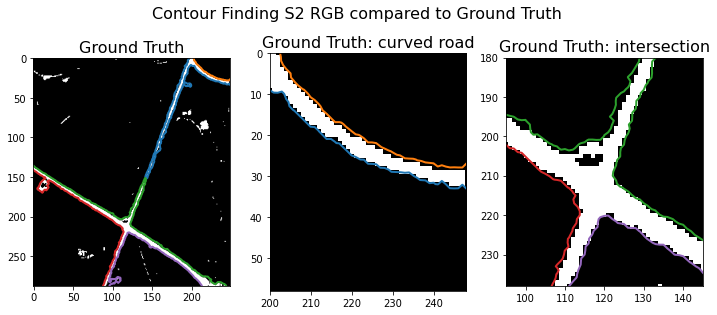

In [43]:
fig, ax = plt.subplots(1, 3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Contour Finding S2 RGB compared to Ground Truth', ha='center',fontsize = 16)

ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth',fontsize=16)
for contour in no_loops2:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2)

ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title('Ground Truth: curved road',fontsize=16)
ax[1].set_xlim([200,248]), ax[1].set_ylim([0,58]), ax[1].invert_yaxis()
for contour in no_loops2:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

ax[2].imshow(ground_truth, cmap='gray')
ax[2].set_title('Ground Truth: intersection',fontsize=16)
ax[2].set_xlim([95,145]), ax[2].set_ylim([180,238]),  ax[2].invert_yaxis()
for contour in no_loops2:
    ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)

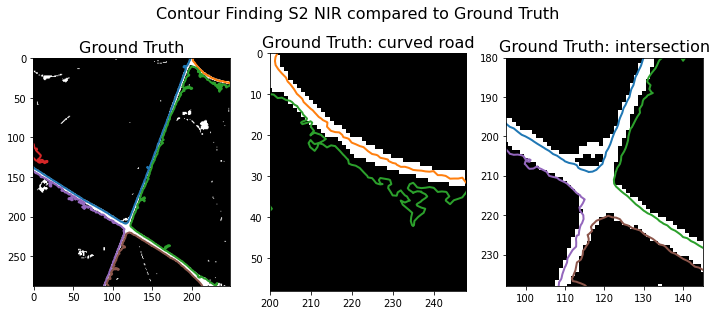

In [44]:
fig, ax = plt.subplots(1, 3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Contour Finding S2 NIR compared to Ground Truth', ha='center',fontsize = 16)

ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth',fontsize=16)
for contour in no_loops_NIR2:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2)

ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title('Ground Truth: curved road',fontsize=16)
ax[1].set_xlim([200,248]), ax[1].set_ylim([0,58]), ax[1].invert_yaxis()
for contour in no_loops_NIR2:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

ax[2].imshow(ground_truth, cmap='gray')
ax[2].set_title('Ground Truth: intersection',fontsize=16)
ax[2].set_xlim([95,145]), ax[2].set_ylim([180,238]),  ax[2].invert_yaxis()
for contour in no_loops_NIR2:
    ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)

## 3.3 Edge detection

Now, the edge detection algorithms will be tested and applied to the images.

In [45]:
def pixelreverse(image,tol):    
    return image < tol

def noisequantization(image,zone):
    return sum(sum(image[zone[0]:zone[1]+1,zone[2]:zone[3]+1]))

def isolatepoint(arr,thresh):
    m,n = len(arr),len(arr[0])
    filtr_arr = np.ones((m,n))
    for i in range(m):
        for j in range(n):
            if i == 0 or i == m or j == 0 or j == n: #edge point
                filtr_arr[i,j] = 0
            else:
                window = arr[i-1:i+1,j-1:j+1]
                if sum(sum(window)) < thresh: #isolated point
                    filtr_arr[i,j] = 0
    return filtr_arr

def quality_detected_roads(ground_truth, detected_roads):
# compute how many (percentage) of the pixels of the ground_truth are actually detected
    m,n = ground_truth.shape
    count = 0
    for i in range(m):
        for j in range(n):
             if ground_truth[i,j] == 1 and detected_roads[i,j] == 1 :
                    count += 1
    return count/sum(sum(ground_truth))

def noisequantization(ground_truth, detected_roads):
    m,n = ground_truth.shape
    count = 0
    for i in range(m):
        for j in range(n):
             if ground_truth[i,j] == 0 and detected_roads[i,j] == 1:
                    count += 1
    return count

#### 3.3.1 Edge detection for the S2 RGB image

In [46]:
image = masked_S2

#image = filtered_image_S2

edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)
edge_scharr = filters.scharr(image)
edge_prewitt = filters.prewitt(image)

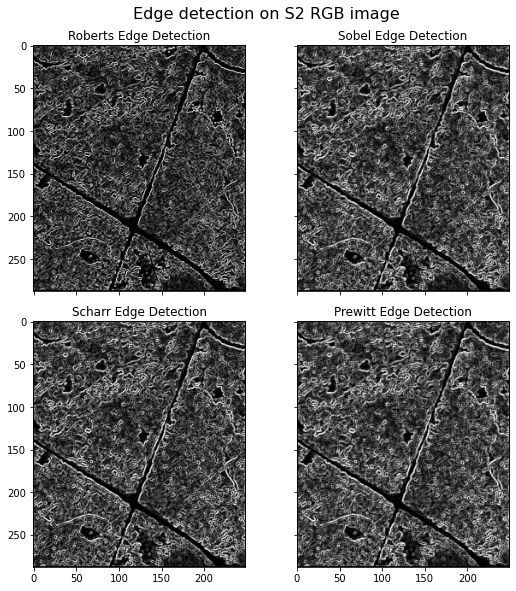

In [47]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()
ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Edge detection on S2 RGB image', ha='center',fontsize = 16)

plt.tight_layout()
plt.show()

These filters detect a lot of edges. However, the middle of the roads are black. To solve this problem, the same trick as for the baseline generation will be applied. However, this time, pixels with a value below a certain threshold will be set to 1, and all other pixels will be set to 0.

In [48]:
thresh_1 = 0.025244897959183676 #value derived from complete algorithm below
thresh_2 = 0.0273

edge_roberts_rev = pixelreverse(edge_roberts,thresh_1)
edge_sobel_rev =  pixelreverse(edge_sobel,thresh_1)
edge_scharr_rev =  pixelreverse(edge_scharr,thresh_2)
edge_prewitt_rev =  pixelreverse(edge_prewitt,thresh_2)

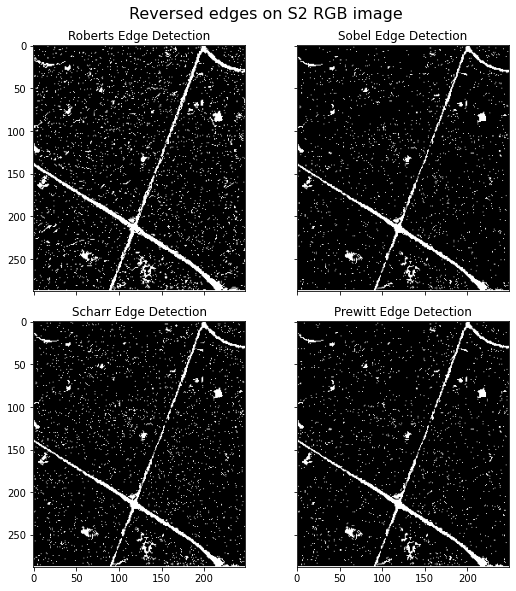

In [49]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()
ax[0].imshow(edge_roberts_rev, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_rev, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_rev, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_rev, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Reversed edges on S2 RGB image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

To narrow the detected roads, these images (consisting entirely of 1's and 0's) will be subjected to skeletonization. This is a procedure that iteratively removes the border pixels, until a line of 1 pixel remains.

In [50]:
edge_roberts_skeleton = skeletonize(edge_roberts_rev)
edge_sobel_skeleton = skeletonize(edge_sobel_rev)
edge_scharr_skeleton = skeletonize(edge_scharr_rev)
edge_prewitt_skeleton = skeletonize(edge_prewitt_rev)

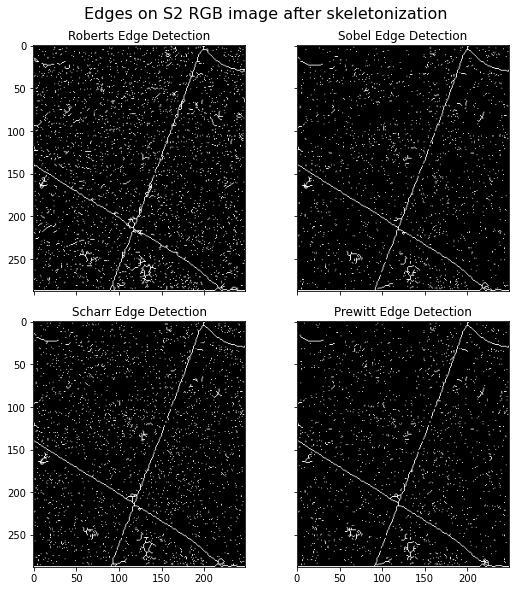

In [51]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Edges on S2 RGB image after skeletonization', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

The roads are now clearly visibile, but there is still a lot of noise present. At first sight, one cannot simply indicate the best filter. A metric to assess the quality of the different filters is thus needed. As first quality indicator, the resulting noise will be considered. A function to quantify the noise, is given in 'Supporting function' section.

In [52]:
noise_roberts = noisequantization(ground_truth, edge_roberts_skeleton)
noise_sobel = noisequantization(ground_truth, edge_sobel_skeleton)
noise_scharr = noisequantization(ground_truth, edge_scharr_skeleton)
noise_prewitt = noisequantization(ground_truth, edge_prewitt_skeleton)

noise_roberts, noise_sobel, noise_scharr, noise_prewitt

(4220, 2741, 3340, 2714)

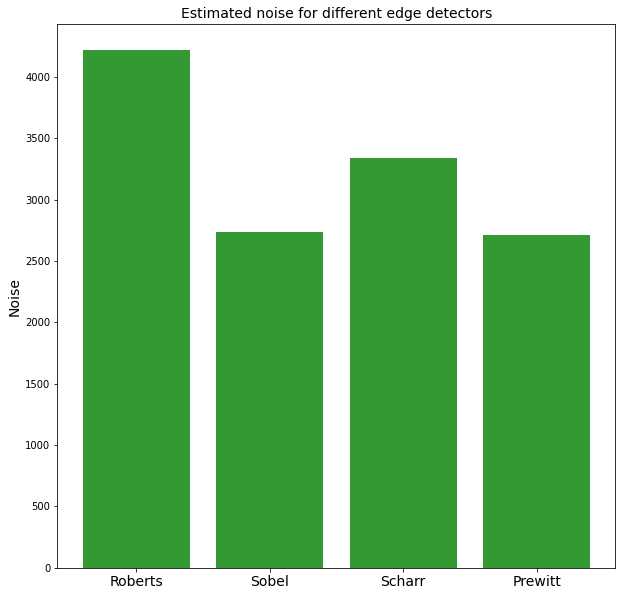

In [53]:
edge_detectors = ('Roberts', 'Sobel', 'Scharr', 'Prewitt')
x_pos = np.arange(len(edge_detectors))
noise = [noise_roberts, noise_sobel, noise_scharr, noise_prewitt]

plt.figure(figsize=(10,10))
plt.bar(x_pos, noise, align='center', alpha=0.8, color= 'g')
plt.xticks(x_pos, edge_detectors, fontsize=14)
plt.ylabel('Noise', fontsize=14)
plt.title('Estimated noise for different edge detectors', fontsize=14)

plt.show()

From the above bar chart, it is clear that the Roberts edge detector performs worst. We also notice that all detetctors have a fairly high noise value. We will try to improve this by getting rid of the isolated noise points. This function is again given in the 'Supporting functions' section.

In [54]:
edge_roberts_filtr = isolatepoint(edge_roberts_rev, 3)
edge_sobel_filtr = isolatepoint(edge_sobel_rev, 3)
edge_scharr_filtr = isolatepoint(edge_scharr_rev, 3)
edge_prewitt_filtr = isolatepoint(edge_prewitt_rev, 3)

edge_roberts_skeleton_filtr = skeletonize(edge_roberts_filtr)
edge_sobel_skeleton_filtr = skeletonize(edge_sobel_filtr)
edge_scharr_skeleton_filtr = skeletonize(edge_scharr_filtr)
edge_prewitt_skeleton_filtr = skeletonize(edge_prewitt_filtr)

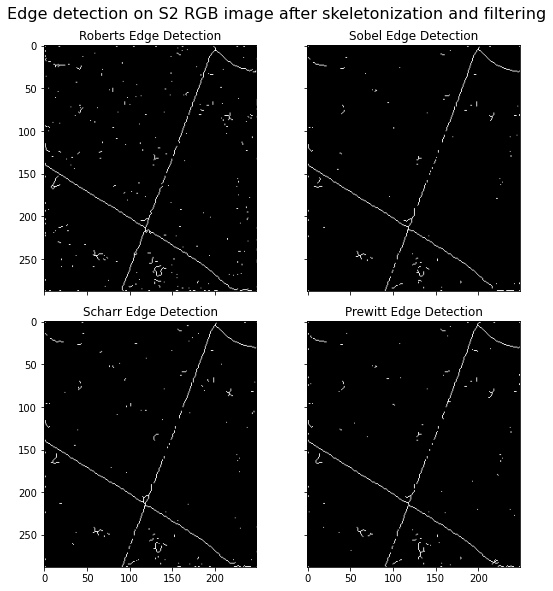

In [55]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_filtr, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_filtr, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_filtr, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_filtr, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Edge detection on S2 RGB image after skeletonization and filtering', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

We can visually see that there is a lot less noise after applying this filter. By calculating the noise in the exact same way as before, we see that there is more or less a factor 10-15 less noise. This is a very satisfying result.

In [56]:
noise_roberts_filtr= noisequantization(ground_truth, edge_roberts_skeleton_filtr)
noise_sobel_filtr = noisequantization(ground_truth, edge_sobel_skeleton_filtr)
noise_scharr_filtr = noisequantization(ground_truth, edge_scharr_skeleton_filtr)
noise_prewitt_filtr = noisequantization(ground_truth, edge_prewitt_skeleton_filtr)

noise_roberts_filtr, noise_sobel_filtr, noise_scharr_filtr, noise_prewitt_filtr

(469, 198, 252, 244)

In [57]:
noise_roberts/noise_roberts_filtr, noise_sobel/noise_sobel_filtr, noise_scharr/noise_scharr_filtr, noise_prewitt/noise_prewitt_filtr

(8.997867803837954, 13.843434343434344, 13.253968253968255, 11.12295081967213)

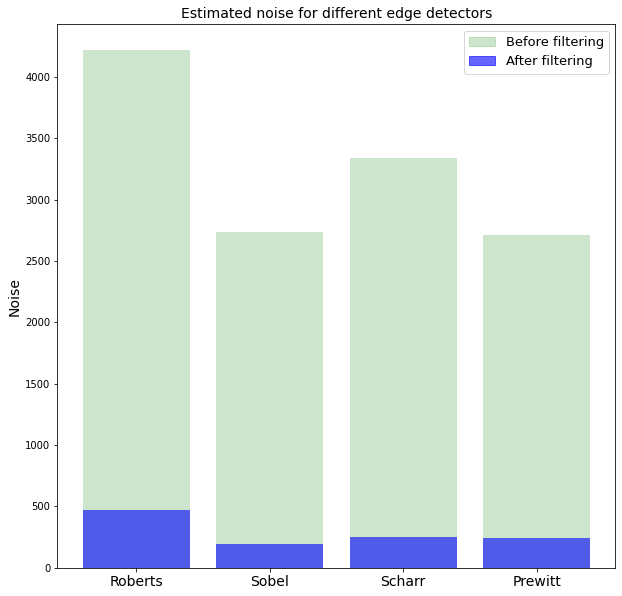

In [58]:
edge_detectors = ('Roberts', 'Sobel', 'Scharr', 'Prewitt')
x_pos = np.arange(len(edge_detectors))
noise = [noise_roberts, noise_sobel, noise_scharr, noise_prewitt]
noise_filtr = [noise_roberts_filtr, noise_sobel_filtr, noise_scharr_filtr, noise_prewitt_filtr]

plt.figure(figsize=(10,10))
plt.bar(x_pos, noise, align='center', alpha=0.2, color= 'g')
plt.bar(x_pos, noise_filtr, align='center', alpha=0.6, color= 'b')
plt.xticks(x_pos, edge_detectors, fontsize=14)
plt.ylabel('Noise', fontsize=14)
plt.title('Estimated noise for different edge detectors', fontsize=14)
    
colors = {'Before filtering':'green', 'After filtering':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
leg = plt.legend(handles, labels,fontsize=13)
for ind, lh in enumerate(leg.legendHandles): 
    lh.set_alpha(0.2+0.4*ind)

plt.show()

Finally, the extracted edges (=roads) for the Sobel edge detector are shown overlayed on the ground truth. It is clear that the roads are quite well extracted, even though not all noise points have been filtered out. 

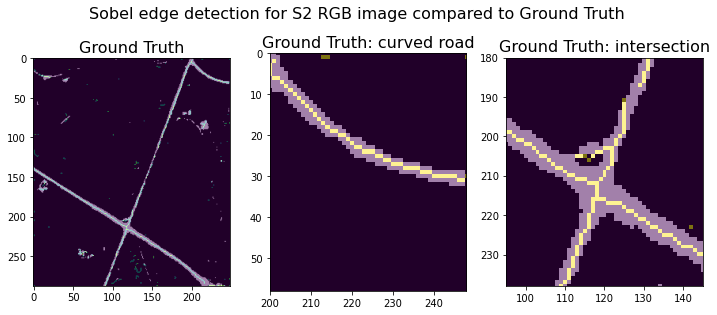

In [59]:
a = 0.5
fig, ax = plt.subplots(1, 3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Sobel edge detection for S2 RGB image compared to Ground Truth', ha='center',fontsize = 16)

ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth',fontsize=16)
ax[0].imshow(edge_sobel_skeleton_filtr, alpha=a)

ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title('Ground Truth: curved road',fontsize=16)
ax[1].imshow(edge_sobel_skeleton_filtr, alpha=a)
ax[1].set_xlim([200,248]), ax[1].set_ylim([0,58]), ax[1].invert_yaxis()

ax[2].imshow(ground_truth, cmap='gray')
ax[2].set_title('Ground Truth: intersection',fontsize=16)
ax[2].set_xlim([95,145]), ax[2].set_ylim([180,238]),  ax[2].invert_yaxis()
ax[2].imshow(edge_sobel_skeleton_filtr, alpha=a)

Visually, this looks quite good. Now, we have to come up with a way to quantize how much of the detected pixels actually belong to the detected toads, and how much of the roads are actually detected. For this, we create the function *quality_detected_roads*. The results are given below.

In [60]:
ground_truth_extract_curve = ground_truth[0:58,200:250]
ground_truth_extract_intersect = ground_truth[180:238, 95:145]

detected_roads = edge_sobel_skeleton_filtr
detected_roads_curve = edge_sobel_skeleton_filtr[0:58,200:250]
detected_roads_intersect = edge_sobel_skeleton_filtr[180:238, 95:145]

quality_detected_roads(ground_truth, detected_roads), quality_detected_roads(ground_truth_extract_curve, detected_roads_curve), quality_detected_roads(ground_truth_extract_intersect, detected_roads_intersect)

(0.190825103536158, 0.2350230414746544, 0.18686868686868688)

This seems like a pretty poor value. However, one should take into account that the detected roads have been skeletonized, whereas the ground truth is not. Therefore, one should intepret this result with care.

#### 3.3.2 Edge detection for the S2 NIR image

The same procedure as for the visible image will now be repeated for the NIR image. We start with applying the 4 different filters to the image.

In [61]:
image = masked_S2_NIR

edge_roberts_NIR = filters.roberts(image)
edge_sobel_NIR = filters.sobel(image)
edge_scharr_NIR = filters.scharr(image)
edge_prewitt_NIR = filters.prewitt(image)

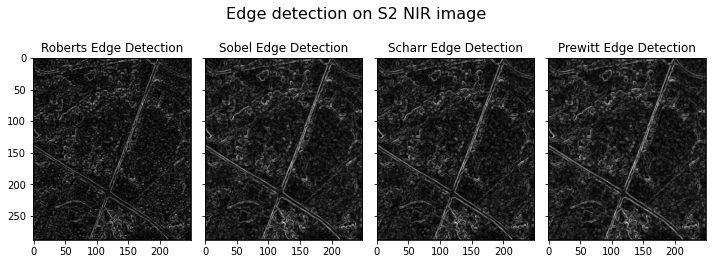

In [62]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(edge_roberts_NIR, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_NIR, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_NIR, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_NIR, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on S2 NIR image', ha='center',fontsize = 16)

plt.tight_layout()
plt.show()

We immediately notice that now the contours of the roads are picked up, instead of the roads itself. This will yield 'inverse' results in the remainder of this report.

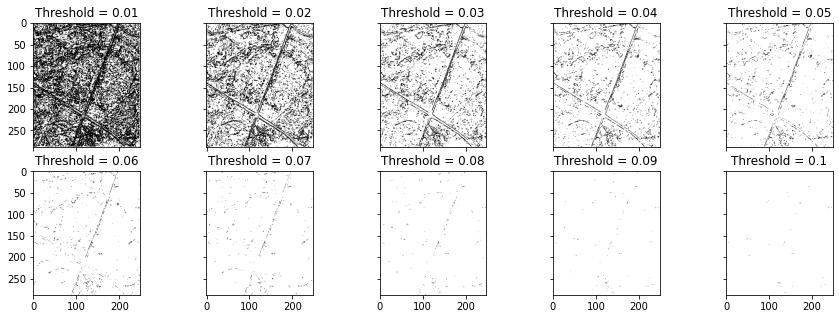

In [63]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')

for idx in range(10):
    edges_roberts = pixelreverse(edge_roberts_NIR,(idx+1)/100)
    ax[idx].imshow(edges_roberts, cmap=plt.cm.gray)
    ax[idx].set_title('Threshold = {}'.format((idx+1)/100))

Based on the figure above, the threshold is set to 0.02.

In [64]:
thresh = 0.02
edge_roberts_rev_NIR = pixelreverse(edge_roberts_NIR,thresh)
edge_sobel_rev_NIR =  pixelreverse(edge_sobel_NIR,thresh)
edge_scharr_rev_NIR =  pixelreverse(edge_scharr_NIR,thresh)
edge_prewitt_rev_NIR =  pixelreverse(edge_prewitt_NIR,thresh)

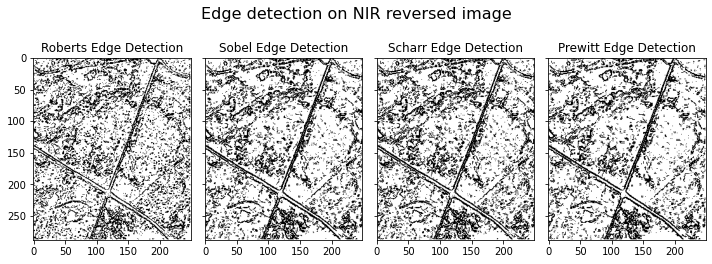

In [65]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(edge_roberts_rev_NIR, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_rev_NIR, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_rev_NIR, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_rev_NIR, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on NIR reversed image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

In [66]:
edge_roberts_skeleton_NIR = skeletonize(edge_roberts_rev_NIR)
edge_sobel_skeleton_NIR = skeletonize(edge_sobel_rev_NIR)
edge_scharr_skeleton_NIR = skeletonize(edge_scharr_rev_NIR)
edge_prewitt_skeleton_NIR = skeletonize(edge_prewitt_rev_NIR)

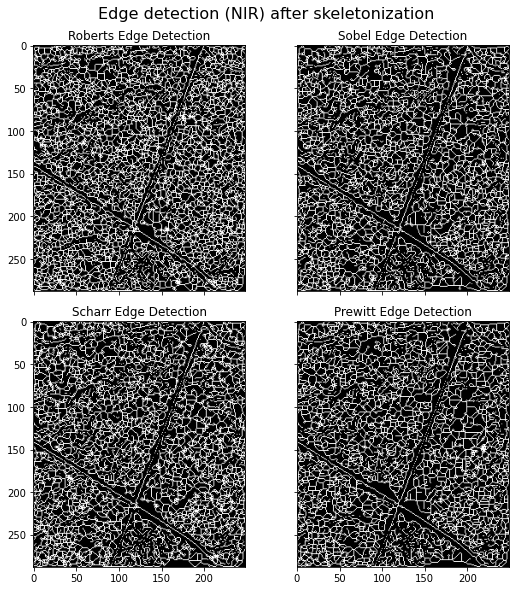

In [67]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_NIR, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_NIR, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_NIR, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_NIR, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Edge detection (NIR) after skeletonization', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

In [68]:
edge_roberts_filtr_NIR = isolatepoint(edge_roberts_rev_NIR, 3)
edge_sobel_filtr_NIR = isolatepoint(edge_sobel_rev_NIR, 3)
edge_scharr_filtr_NIR = isolatepoint(edge_scharr_rev_NIR, 3)
edge_prewitt_filtr_NIR = isolatepoint(edge_prewitt_rev_NIR, 3)

edge_roberts_skeleton_filtr_NIR = skeletonize(edge_roberts_filtr_NIR)
edge_sobel_skeleton_filtr_NIR = skeletonize(edge_sobel_filtr_NIR)
edge_scharr_skeleton_filtr_NIR = skeletonize(edge_scharr_filtr_NIR)
edge_prewitt_skeleton_filtr_NIR = skeletonize(edge_prewitt_filtr_NIR)

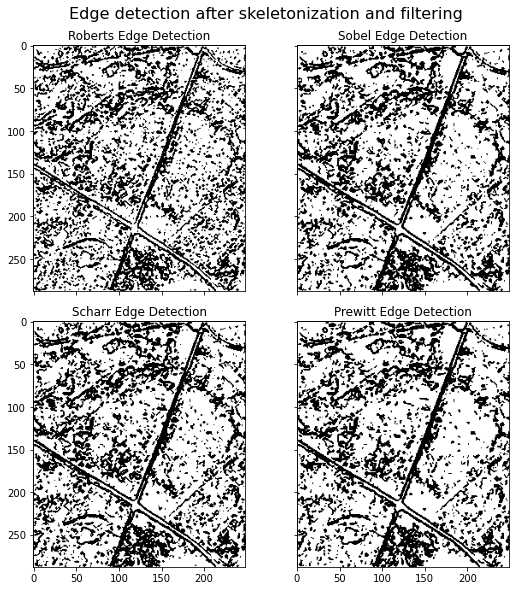

In [69]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(edge_roberts_filtr_NIR, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_filtr_NIR, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_filtr_NIR, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_filtr_NIR, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Edge detection after skeletonization and filtering', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

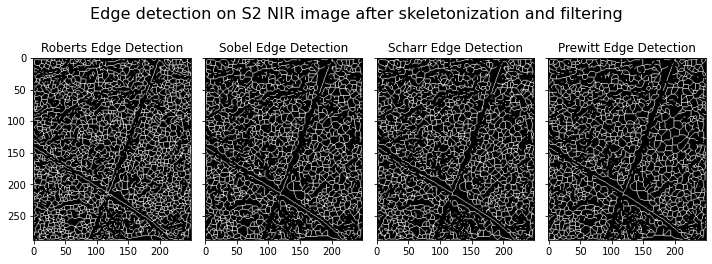

In [70]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_filtr_NIR, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_filtr_NIR, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_filtr_NIR, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_filtr_NIR, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on S2 NIR image after skeletonization and filtering', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

We can immediately see that these results are a lot worse than the results obtained in the visual domain. This is confirmed by a noise calculation.

In [71]:
noise_roberts_filtr_NIR = noisequantization(ground_truth, edge_roberts_skeleton_filtr_NIR)
noise_sobel_filtr_NIR = noisequantization(ground_truth, edge_sobel_skeleton_filtr_NIR)
noise_scharr_filtr_NIR = noisequantization(ground_truth, edge_scharr_skeleton_filtr_NIR)
noise_prewitt_filtr_NIR = noisequantization(ground_truth, edge_prewitt_skeleton_filtr_NIR)

noise_roberts_filtr_NIR, noise_sobel_filtr_NIR, noise_scharr_filtr_NIR, noise_prewitt_filtr_NIR

(15278, 13004, 13210, 12490)

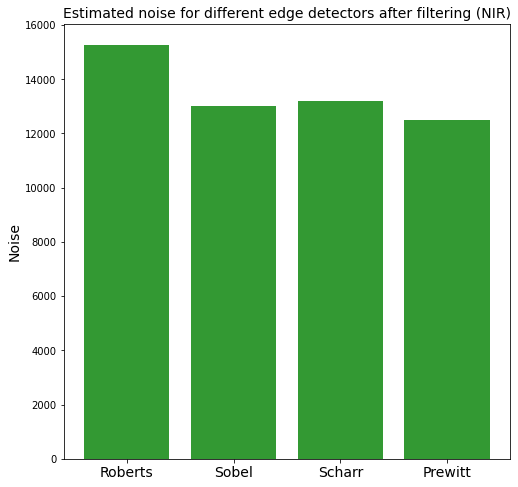

In [72]:
edge_detectors = ('Roberts', 'Sobel', 'Scharr', 'Prewitt')
x_pos = np.arange(len(edge_detectors))
noise = [noise_roberts_filtr_NIR, noise_sobel_filtr_NIR, noise_scharr_filtr_NIR, noise_prewitt_filtr_NIR]

plt.figure(figsize=(8,8))
plt.bar(x_pos, noise, align='center', alpha=0.8, color= 'g')
plt.xticks(x_pos, edge_detectors, fontsize=14)
plt.ylabel('Noise', fontsize=14)
plt.title('Estimated noise for different edge detectors after filtering (NIR)', fontsize=14)

plt.show()

We can thus easily conclude that it is best to work with the visual Sentinel-2 images.

#### 3.3.3 Edge detection for the Sentinel-1 image

Lastly, we will apply the edge detection to the S1 image. As we have seen before, the VV image clearly has the best contrast, so this is the image we will be using.

In [73]:
image = exposure.equalize_hist(images_aoi['VV'])

edge_roberts_S1 = filters.roberts(image)
edge_sobel_S1 = filters.sobel(image)
edge_scharr_S1 = filters.scharr(image)
edge_prewitt_S1 = filters.prewitt(image)

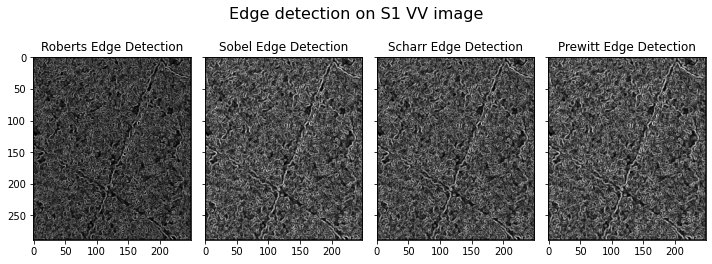

In [74]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(edge_roberts_S1, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_S1, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_S1, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_S1, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on S1 VV image', ha='center',fontsize = 16)

plt.tight_layout()
plt.show()

In [75]:
thresh = 0.03
edge_roberts_rev_S1 = pixelreverse(edge_roberts_S1,thresh)
edge_sobel_rev_S1 =  pixelreverse(edge_sobel_S1,thresh)
edge_scharr_rev_S1 =  pixelreverse(edge_scharr_S1,thresh)
edge_prewitt_rev_S1 =  pixelreverse(edge_prewitt_S1,thresh)

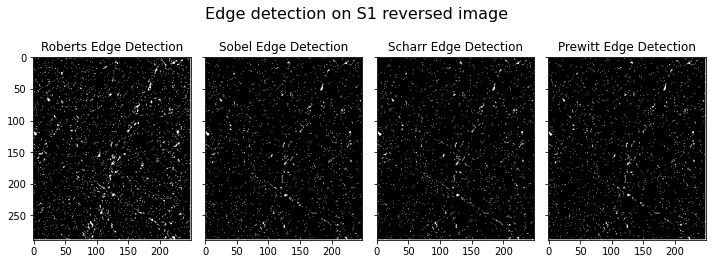

In [76]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(edge_roberts_rev_S1, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_rev_S1, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_rev_S1, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_rev_S1, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on S1 reversed image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

Now we will apply skeletonization.

In [77]:
edge_roberts_skeleton_S1 = skeletonize(edge_roberts_rev_S1)
edge_sobel_skeleton_S1 = skeletonize(edge_sobel_rev_S1)
edge_scharr_skeleton_S1 = skeletonize(edge_scharr_rev_S1)
edge_prewitt_skeleton_S1 = skeletonize(edge_prewitt_rev_S1)

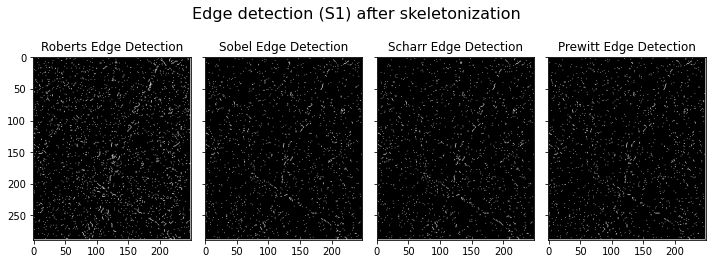

In [78]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_S1, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_S1, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_S1, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_S1, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection (S1) after skeletonization', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

Next, we filter the isolated noise points and apply skeletonization to these filtered images.

In [79]:
edge_roberts_filtr_S1 = isolatepoint(edge_roberts_rev_S1, 4)
edge_sobel_filtr_S1 = isolatepoint(edge_sobel_rev_S1, 4)
edge_scharr_filtr_S1 = isolatepoint(edge_scharr_rev_S1, 4)
edge_prewitt_filtr_S1 = isolatepoint(edge_prewitt_rev_S1, 4)

edge_roberts_skeleton_filtr_S1 = skeletonize(edge_roberts_filtr_S1)
edge_sobel_skeleton_filtr_S1 = skeletonize(edge_sobel_filtr_S1)
edge_scharr_skeleton_filtr_S1 = skeletonize(edge_scharr_filtr_S1)
edge_prewitt_skeleton_filtr_S1 = skeletonize(edge_prewitt_filtr_S1)

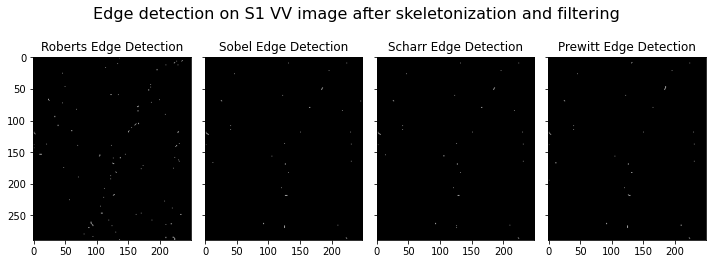

In [80]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_filtr_S1, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_filtr_S1, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_filtr_S1, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_filtr_S1, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on S1 VV image after skeletonization and filtering', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

We see that almost all information about the roads is lost. Only the Roberts edge detector shows a vague sign of the main roads, for all the other filters there is almost nothing left. This is caused by the noise in the S1 SAR images. We will try to solve this by applying a Gaussian filter, which is essentially a low pass filter that will reduce noise.

In [81]:
sig = 2.5
k = 2*math.ceil(2*sig)+1
#k = 13

image = cv.GaussianBlur(masked_S1,(k,k),sig)
edge_roberts_S1_gaus = filters.roberts(image)
edge_sobel_S1_gaus = filters.sobel(image)
edge_scharr_S1_gaus = filters.scharr(image)
edge_prewitt_S1_gaus = filters.prewitt(image)

In [ ]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(edge_roberts_S1_gaus, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_S1_gaus, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_S1_gaus, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_S1_gaus, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection on Gaussian filtered S1 VV image', ha='center',fontsize = 16)

plt.tight_layout()
plt.show()

In [ ]:
image = edge_roberts_S1_gaus
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)


for idx in range(10):
    edges_roberts = pixelreverse(edge_roberts_S1_gaus,(idx+1)/100)
    ax[idx].imshow(edges_roberts, cmap=plt.cm.gray)
    ax[idx].set_title('Threshold = {}'.format((idx+1)/100))

In [ ]:
thresh = 0.03
edge_roberts_rev_S1_gaus = pixelreverse(edge_roberts_S1_gaus,thresh)
edge_sobel_rev_S1_gaus =  pixelreverse(edge_sobel_S1_gaus,thresh)
edge_scharr_rev_S1_gaus =  pixelreverse(edge_scharr_S1_gaus,thresh)
edge_prewitt_rev_S1_gaus =  pixelreverse(edge_prewitt_S1_gaus,thresh)

In [ ]:
fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(edge_roberts_rev_S1_gaus, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_rev_S1_gaus, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_rev_S1_gaus, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_rev_S1_gaus, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5,0.68, 'Edge detection on S1 reversed Gaussian image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

In [ ]:
edge_roberts_skeleton_S1_gaus = skeletonize(edge_roberts_rev_S1_gaus)
edge_sobel_skeleton_S1_gaus = skeletonize(edge_sobel_rev_S1_gaus)
edge_scharr_skeleton_S1_gaus = skeletonize(edge_scharr_rev_S1_gaus)
edge_prewitt_skeleton_S1_gaus = skeletonize(edge_prewitt_rev_S1_gaus)

fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_S1_gaus, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_S1_gaus, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_S1_gaus, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_S1_gaus, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 1, 'Edge detection (S1) after skeletonization', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

In [ ]:
edge_roberts_filtr_S1_gaus = isolatepoint(edge_roberts_rev_S1_gaus, 2)
edge_sobel_filtr_S1_gaus = isolatepoint(edge_sobel_rev_S1_gaus, 2)
edge_scharr_filtr_S1_gaus = isolatepoint(edge_scharr_rev_S1_gaus, 2)
edge_prewitt_filtr_S1_gaus = isolatepoint(edge_prewitt_rev_S1_gaus, 2)

edge_roberts_skeleton_filtr_S1_gaus = skeletonize(edge_roberts_filtr_S1_gaus)
edge_sobel_skeleton_filtr_S1_gaus = skeletonize(edge_sobel_filtr_S1_gaus)
edge_scharr_skeleton_filtr_S1_gaus = skeletonize(edge_scharr_filtr_S1_gaus)
edge_prewitt_skeleton_filtr_S1_gaus = skeletonize(edge_prewitt_filtr_S1_gaus)

fig, axes = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(edge_roberts_skeleton_filtr_S1_gaus, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel_skeleton_filtr_S1_gaus, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_scharr_skeleton_filtr_S1_gaus, cmap=plt.cm.gray)
ax[2].set_title('Scharr Edge Detection')

ax[3].imshow(edge_prewitt_skeleton_filtr_S1_gaus, cmap=plt.cm.gray)
ax[3].set_title('Prewitt Edge Detection')

plt.figtext(0.5, 0.68, 'Edge detection after skeletonization and filtering', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

From all of the previous calculations, we can conclude that the S2 visible images are best suited for Edge detetction algorithms.

### 3.4 Canny filter

As a final edge detector, the Canny filter will be considered.

In [ ]:
image = masked_S2

fig, axes = plt.subplots(1, 4, figsize=(12, 12), sharex=True, sharey=True)
plt.figtext(0.5, 0.63, 'Determining $\sigma$ for the S2 RGB Image', ha='center',fontsize = 16)
ax = axes.ravel()

for idx in range(4):
    edges = canny(image, 2*idx)
    ax[idx].imshow(edges, cmap=plt.cm.gray)
    ax[idx].set_title('$\sigma$ = {}'.format(idx*2))

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 12), sharex=True, sharey=True)
plt.figtext(0.5, 0.63, 'Determining the threshold values for the S2 RGB Image', ha='center',fontsize = 16)
ax = axes.ravel()

for idx in range(4):
    edges = canny(image, 4, (idx+1)/20, 2*(idx+1)/20)
    ax[idx].imshow(edges, cmap=plt.cm.gray)
    ax[idx].set_title('$t_{low} = $ %.2f, $t_{high} = $ %.2f' %((idx+1)/20, 2*(idx+1)/20))

In [ ]:
ground_truth = groundtruthgenerator(rgb2gray(img_RGB),0.95)
canny_edges = canny(masked_S2, 4, 0.15, 0.3)
a = 0.5

fig, ax = plt.subplots(1, 3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Canny edge detection for S2 RGB image compared to Ground Truth', ha='center',fontsize = 16)

ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth',fontsize=16)
ax[0].imshow(canny_edges, alpha=a)

ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title('Ground Truth: curved road',fontsize=16)
ax[1].imshow(canny_edges, alpha=a)
ax[1].set_xlim([200,248]), ax[1].set_ylim([0,58]), ax[1].invert_yaxis()

ax[2].imshow(ground_truth, cmap='gray')
ax[2].set_title('Ground Truth: intersection',fontsize=16)
ax[2].set_xlim([95,145]), ax[2].set_ylim([180,238]),  ax[2].invert_yaxis()
ax[2].imshow(canny_edges, alpha=a)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(masked_S2, cmap='gray')
ax.imshow(canny_edges, alpha=a)
ax.set_title('Canny edge detection compared to S2 RGB Image', fontsize = 16)
plt.show()

### 3.5 Ridge operators

#### 3.5.0 Supporting functions

In [ ]:
def original(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image

#### 3.5.1 Ridge detection on S2 RGB Image

First, the 4 different ridge operators will be tested on the S2 RGB Image. From the figure below, it is clear that the Hessian ridge operator yields the most promising results.

In [ ]:
image = masked_S2
cmap = plt.cm.gray

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

for i, black_ridges in enumerate([True, False]):
    for j, (func, sigmas) in enumerate([
            (original, None),
            (meijering, [1]),
            (sato, [1]),
            (frangi, [1]),
            (hessian, [1]),
    ]):
        result = func(image, black_ridges=black_ridges, sigmas=sigmas)
        ax[i, j].imshow(result, cmap=cmap)
        if i == 0:
            title = func.__name__
            if sigmas:
                title += '\n' '$\sigma$ = {}'.format(sigmas[0])
            ax[i, j].set_title(title, fontsize = 16)
        if j == 0:
            ax[i, j].set_ylabel('Black Ridges = {}'.format(black_ridges),fontsize=16)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.figtext(0.5, 0.96,'Ridge Detection Algorithms on S2 RGB Image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

Now that we have chosen a ridge operator to work with, we will try to find the most suitable parameters.

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
ax = axes.ravel()
for i, sigmas in enumerate([
    None,
    [1],
    range(1, 5),
    range(1, 9),
    range(1, 13)
]):
    if i == 0:
        result = original(image)
        skeletonized_result = result
        title = 'Original'
        ax[i+5].set_title(title, fontsize = 14)
    else:
        result = hessian(image, black_ridges=True, sigmas=sigmas)
        result = isolatepoint(result,3)
        title = "$\sigma_{max}$ = " + "{}".format(sigmas[-1])
        skeletonized_result = skeletonize(result)
        ax[i+5].set_title('After skeletonization', fontsize = 14)
    
    ax[i].imshow(result, cmap=cmap), ax[i+5].imshow(skeletonized_result, cmap=cmap)
    ax[i].set_title(title, fontsize = 14)
    
    ax[i].set_xticks([]), ax[i+5].set_xticks([])
    ax[i].set_yticks([]), ax[i+5].set_yticks([])
plt.figtext(0.5, 0.94,'Hessian Ridge Detection on S2 RGB Image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

It is clear that the larger the scale range of $\sigma$, the more the noise is filtered out. However, the price to pay is a reduction in the road detection quality. The ideal maximum limit for $\sigma$ will be somewhere between 7 and 11. To find the best value in this range, the noise is calculated for every value. The result of this noise calculation is given below.

In [ ]:
limit = np.linspace(2,13,12)
noise_estimation_zone = (35,120,0,130)
noise = []
noise_isolate = []
for i, lim in enumerate(limit):
    sigmas = range(1,np.int64(lim))
    result = skeletonize(hessian(masked_S2, black_ridges=True, sigmas=sigmas))
    result_isolate = skeletonize(isolatepoint(hessian(masked_S2, black_ridges=True, sigmas=sigmas),3))
    noise.append(noisequantization(ground_truth,result))
    noise_isolate.append(noisequantization(ground_truth,result_isolate))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(limit-1,noise_isolate,linewidth=3)
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('$\sigma_{max}$', fontsize = 16), plt.ylabel('Detected noise points', fontsize = 16)
plt.ylim([0, 12000])
plt.title('Detetcted noise points for the Hessian Ridge Detector', fontsize = 16)
plt.legend(['S2 RGB Image'])
plt.show()

Fromthe figure, we can deduce that the noise somewhat stabilizes around a value of $\sigma_{max}$ = 9.

#### 3.5.2 Ridge Detection on S2 NIR Image

The same procedure will now be repeated for the S2 NIR image. Here, we see that the detector works best for 'Black Ridges = False'.

In [ ]:
image = masked_S2_NIR
cmap = plt.cm.gray

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

for i, black_ridges in enumerate([True, False]):
    for j, (func, sigmas) in enumerate([
            (original, None),
            (meijering, [1]),
            (sato, [1]),
            (frangi, [1]),
            (hessian, [1]),
    ]):
        result = func(image, black_ridges=black_ridges, sigmas=sigmas)
        ax[i, j].imshow(result, cmap=cmap)
        if i == 0:
            title = func.__name__
            if sigmas:
                title += '\n' '$\sigma$ = {}'.format(sigmas[0])
            ax[i, j].set_title(title, fontsize = 16)
        if j == 0:
            ax[i, j].set_ylabel('Black Ridges = {}'.format(black_ridges),fontsize=16)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.figtext(0.5, 0.96,'Ridge Detection Algorithms on S2 NIR Image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
ax = axes.ravel()
for i, sigmas in enumerate([
    None,
    [1],
    range(1, 5),
    range(1, 9),
    range(1, 13)
]):
    if i == 0:
        result = original(image)
        skeletonized_result = result
        title = 'Original'
        ax[i+5].set_title(title, fontsize = 14)
    else:
        result = hessian(image, black_ridges=False, sigmas=sigmas)
        resukt = isolatepoint(result,3)
        title = "$\sigma_{max}$ = " + "{}".format(sigmas[-1])
        skeletonized_result = skeletonize(result)
        ax[i+5].set_title('After skeletonization', fontsize = 14)
    
    ax[i].imshow(result, cmap=cmap), ax[i+5].imshow(skeletonized_result, cmap=cmap)
    ax[i].set_title(title, fontsize = 14)
    
    ax[i].set_xticks([]), ax[i+5].set_xticks([])
    ax[i].set_yticks([]), ax[i+5].set_yticks([])
plt.figtext(0.5, 0.94,'Hessian Ridge Detection on S2 NIR Image', ha='center',fontsize = 16)
plt.tight_layout()
plt.show()

Here, we see that the results are still pretty good, but especially the curved road is detected less accurately. The optimal value for $\sigma_{max}$ will lay somewhere around 5. 

In [ ]:
limit = np.linspace(2,13,12)
noise_estimation_zone = (35,120,0,130)
noise_NIR = []
noise_isolate_NIR = []
for i, lim in enumerate(limit):
    sigmas = range(1,np.int64(lim))
    result = skeletonize(hessian(masked_S2_NIR, black_ridges=False, sigmas=sigmas))
    result_isolate = skeletonize(isolatepoint(hessian(masked_S2_NIR, black_ridges=False, sigmas=sigmas),3))
    noise_NIR.append(noisequantization(ground_truth,result))
    noise_isolate_NIR.append(noisequantization(ground_truth,result_isolate))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(limit-1,noise), plt.plot(limit-1,noise_NIR)
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('$\sigma_{max}$', fontsize = 16), plt.ylabel('Detected noise points', fontsize = 16)
plt.title('Detetcted noise points for the Hessian Ridge Detector', fontsize = 16)
plt.legend(['S2 RGB Image', 'S2 NIR Image'])
plt.show()

The noise is higher for the NIR image than for the RGB image. Especially when comparing $\sigma_{max}$ = 5 for the NIR image and $\sigma_{max}$ = 9 for the RGB image, the RGB image clearly yields better results (2064 << 4141).

The figure below compares the noise of the Ridge Detection algorithm with the Sobel Filter for the S2 RGB image.

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(limit-1,noise_isolate), plt.plot(limit-1,noise_isolate_NIR)
plt.grid(color='k', linestyle=':', linewidth=1)
plt.plot(limit-1, np.ones(len(limit))*noise_sobel_filtr,linestyle='--')
plt.plot(9,noise_isolate[8],'ro'), plt.plot(5,noise_isolate_NIR[4],'ro')
plt.xlabel('$\sigma_{max}$', fontsize = 16), plt.ylabel('Detected noise points', fontsize = 16)
plt.title('Comparison of detetcted noise points', fontsize = 16)
plt.legend(['S2 RGB, Ridge Detection', 'S2 NIR, Ridge Detection','S2 RGB, Sobel Filter','Optimal $\sigma_{max}$'])
plt.show()

From this fiugre, we can conclude that "noisewise", the Hessian Ridge Detector does not even come close to the Sobel Edge Detector for this AOI. However, on the figure below, the Hessian detector is compared to the ground truth to get an idea of how good the roads are detected.

In [ ]:
ground_truth = groundtruthgenerator(rgb2gray(img_RGB),0.95)
ridge = skeletonize(hessian(masked_S2, black_ridges=True, sigmas=range(1,9)))
a = 0.5

fig, ax = plt.subplots(1, 3,figsize=(12,12))
plt.figtext(0.5, 0.68,'Hessian ridge detection for S2 RGB image compared to Ground Truth', ha='center',fontsize = 16)

ax[0].imshow(ground_truth, cmap='gray')
ax[0].set_title('Ground Truth',fontsize=16)
ax[0].imshow(ridge, alpha=a)

ax[1].imshow(ground_truth, cmap='gray')
ax[1].set_title('Ground Truth: curved road',fontsize=16)
ax[1].imshow(ridge, alpha=a)
ax[1].set_xlim([200,248]), ax[1].set_ylim([0,58]), ax[1].invert_yaxis()

ax[2].imshow(ground_truth, cmap='gray')
ax[2].set_title('Ground Truth: intersection',fontsize=16)
ax[2].set_xlim([95,145]), ax[2].set_ylim([180,238]),  ax[2].invert_yaxis()
ax[2].imshow(ridge, alpha=a)

plt.show()

In [ ]:
quality_detected_roads(ground_truth, ridge)*100

## 4. Generation of the Road Vector Layer

### 4.1 Supporting functions

In [ ]:
def edge_extraction(image,th):
    edge = filters.sobel(image)
    edge_thresh = pixelreverse(edge, th)    
    edge_filtr_isolate = isolatepoint(edge_thresh, 3)
    edge_filtr_isolate_skeleton = skeletonize(edge_filtr_isolate)
  
    edges = edge_filtr_isolate_skeleton
    
    return edges

def find_asymptote(quality_vector, threshold):
    qual_norm = quality_vector/np.max(quality_vector)
    steps = qual_norm[1:]-qual_norm[:-1]
    asymptote = np.zeros(len(steps))
    quality_threshold, thresh_chosen = 1, 1
    for ind, step in enumerate(steps):
        if abs(step) < 0.01:
            asymptote[ind] = 1
    for ind, asy in enumerate(asymptote):
        if asy == 1 and sum(asymptote[ind:]) > len(asymptote[ind:])*0.25 and qual_norm[ind]/np.max(qual_norm) > 0.8 or asy == 1 and qual_norm[ind]/np.max(qual_norm) > 0.9:
            quality_threshold = qual_norm[ind]
            thresh_chosen =  threshold[ind]
            break
    return quality_threshold, thresh_chosen

def edge_detection(image, ground_truth, type_filter, thresh, do_plot, do_print, aoi_test):
    if type_filter == 'Roberts':
        edge = filters.roberts(image)
    elif  type_filter == 'Sobel':
        edge = filters.sobel(image)
    elif type_filter == 'Scharr':
        edge = filters.scharr(image)
    elif type_filter == 'Prewitt':
        edge = filters.prewitt(image)
    
    edge_thresh = pixelreverse(edge, thresh)
    edge_skeleton = skeletonize(edge_thresh)
    
    edge_filtr_isolate = isolatepoint(edge_thresh, 3)
    edge_filtr_isolate_skeleton = skeletonize(edge_filtr_isolate)
  
    qual_edges = quality_detected_roads(ground_truth, edge_filtr_isolate_skeleton)
    
    noise = noisequantization(ground_truth, edge_skeleton)
    noise_filtr = noisequantization(ground_truth, edge_filtr_isolate_skeleton)
    
    if aoi_test == 1:
        qual_curve = quality_detected_roads(ground_truth[0:58,200:250], edge_filtr_isolate_skeleton[0:58,200:250])
        qual_intersect = quality_detected_roads(ground_truth[180:238, 95:145], edge_filtr_isolate_skeleton[180:238, 95:145])

    if do_plot:
        a = 0.5
        fig, ax = plt.subplots(1, 3,figsize=(12,12))
        plt.figtext(0.5, 0.68,'{} edge detection for S2 RGB image compared to Ground Truth'.format(type_filter), ha='center',fontsize = 16)

        ax[0].imshow(ground_truth, cmap='gray')
        ax[0].set_title('Ground Truth',fontsize=16)
        ax[0].imshow(edge_filtr_isolate_skeleton, alpha=a)

        ax[1].imshow(ground_truth, cmap='gray')
        ax[1].set_title('Ground Truth: curved road',fontsize=16)
        ax[1].imshow(edge_filtr_isolate_skeleton, alpha=a)
        ax[1].set_xlim([200,248]), ax[1].set_ylim([0,58]), ax[1].invert_yaxis()

        ax[2].imshow(ground_truth, cmap='gray')
        ax[2].set_title('Ground Truth: intersection',fontsize=16)
        ax[2].set_xlim([95,145]), ax[2].set_ylim([180,238]),  ax[2].invert_yaxis()
        ax[2].imshow(edge_filtr_isolate_skeleton, alpha=a)
    if do_print:   
        print("Noise before filtering = {}".format(noise))
        print("Noise after filtering = {}".format(noise_filtr))
        print("Quality of detected roads = {0:.2f} %".format(qual_edges*100))   
    
    if aoi_test == 1:
        return noise, noise_filtr, qual_edges, qual_curve, qual_intersect
    else:
        return noise, noise_filtr, qual_edges

The edge detection function will now be used to determine the best value for *thresh*. Therefore, another function has been defined.

In [ ]:
def find_threshold(upper_limit, steps, image, ground_truth, type_filter, do_plot, aoi_test):
    threshold = np.linspace(0.001,upper_limit,steps)
    noise, qual, qual_curve, qual_intersect = [], [], [], []
    
    for thresh in threshold:
        if aoi_test:
        
            nb, na, qu, qu_curve, qu_intersect = edge_detection(image, ground_truth, type_filter, thresh, 0, 0, aoi_test)
            noise.append(na)
            qual.append(qu*100)
            qual_curve.append(qu_curve*100)
            qual_intersect.append(qu_intersect*100)
            
        else:
            
            nb, na, qu = edge_detection(image, ground_truth, type_filter, thresh, 0, 0, aoi_test)
            noise.append(na)
            qual.append(qu*100)
    
    quality_threshold, thresh_chosen = find_asymptote(qual, threshold)
    
    if aoi_test:
        if do_plot:
            fig, axes = plt.subplots(1, 1, figsize=(15, 7.5))

            plt.plot(threshold, noise/np.max(noise))
            plt.plot(threshold, qual/np.max(qual))
            plt.plot(threshold, qual_curve/np.max(qual_curve))
            plt.plot(threshold, qual_intersect/np.max(qual_intersect))
            plt.plot(np.linspace(-0.01,0.1,len(threshold)), quality_threshold*np.ones(len(threshold)),linestyle ='--', color = 'red',linewidth = 2)
            plt.plot(thresh_chosen, quality_threshold, 'b*', markersize=15)

            plt.grid(color='k', linestyle=':', linewidth=1)
            plt.xlabel('Threshold value', fontsize = 16)
            plt.title('Evaluation of the algorithm for {} detector'.format(type_filter), fontsize = 16)
            plt.legend(['Noise normalized', 'Detection quality normalized', 'Detection quality curve normalized', 
                        'Detection quality intersect normalized','Quality threshold = {0:.4f}'.format(quality_threshold), 'Chosen threshold = {0:.4f}'.format(thresh_chosen)], fontsize = 16)
            plt.xlim([0, 0.105]), plt.ylim([-0.15, 1.05])
            plt.show()

        return thresh_chosen, noise, qual, qual_curve, qual_intersect, quality_threshold, threshold
    else:
        if do_plot:
            fig, axes = plt.subplots(1, 1, figsize=(15, 7.5))

            plt.plot(threshold, noise/np.max(noise))
            plt.plot(threshold, qual/np.max(qual))
            plt.plot(np.linspace(-0.01,0.1,len(threshold)), quality_threshold*np.ones(len(threshold)),linestyle ='--', color = 'red',linewidth = 2)
            plt.plot(thresh_chosen, quality_threshold, 'b*', markersize=15)

            plt.grid(color='k', linestyle=':', linewidth=1)
            plt.xlabel('Threshold value', fontsize = 16)
            plt.title('Evaluation of the algorithm for {} detector'.format(type_filter), fontsize = 16)
            plt.legend(['Noise normalized', 'Detection quality normalized','Quality threshold = {0:.4f}'.format(quality_threshold), 'Chosen threshold = {0:.4f}'.format(thresh_chosen)], fontsize = 16)
            plt.xlim([0, 0.105]), plt.ylim([-0.15, 1.05])
            plt.show()
        
        return thresh_chosen, noise, qual, quality_threshold, threshold

### 4.2 Determination of the best pixel threshold for all 4 edge detectors

#### 4.2.1 Supporting functions

In [ ]:
def edge_detection_S2(upper_limit, steps, image, ground_truth, types, do_plot, aoi_test):
    noise_all, qual_th_all, thresh_chosen_all = [], [], []
    for type_filter in types:
        if aoi_test:
            thresh_chosen, noise, qual, qual_curve, qual_intersect, qu_th, threshold = find_threshold(upper_limit, steps, image, ground_truth, type_filter, do_plot, aoi_test)
        else:
            thresh_chosen, noise, qual, qu_th, threshold = find_threshold(upper_limit, steps, image, ground_truth, type_filter, aoi_test)

        edge_detection(image, ground_truth, type_filter, thresh_chosen, 0, 1, aoi_test)  

#### 4.2.2 Apply edge detection function

In [ ]:
types = ['Roberts', 'Sobel', 'Scharr', 'Prewitt']
edge_detection_S2(0.1, 50, masked_S2, ground_truth, types, 1, 1)

### 4.3 Creation of the algorithm

In [ ]:
def vectorlayer_generation(image, ground_truth, AOI, th, do_plot, stats):
    if th == 'auto':
        threshold = find_threshold(0.8, 50, image, ground_truth, 'Sobel', 1,0)[0]
    else: 
        threshold = th
    
    print('The selected pixel threshold is {}'.format(threshold))
    edges = edge_extraction(image, threshold)
    
    if stats:
        noise, noise_filtr, qual_edges = edge_detection(image, ground_truth, 'Sobel', threshold, 0, 1, 0)
    
    m,n = image.shape
    top, left = AOI[0], AOI[1]
    resolution = 10
    edge_layer_hor, edge_layer_vert = [],  []
    
    for i in range(m):
        for j in range(n):
            if edges[i,j] == True:
                coord = (top-resolution*i, left+resolution*j)
                edge_layer_hor.append(left+resolution*j)
                edge_layer_vert.append(top-resolution*i)
    
    if do_plot:
        fig, ax = plt.subplots(1,2, figsize=(15,10))
        
        ax[0].imshow(image, cmap='gray')
        ax[0].imshow(edges, alpha=0.8, aspect="auto")
        ax[0].set_title('Detected edges', fontsize = 16)
        
        ax[1].plot(edge_layer_hor,edge_layer_vert,'o')
        ax[1].set_title('Road Layer vector', fontsize = 16)
        ax[1].set_xlabel('UTM zone 31N coordinates [m]', fontsize = 14)
        ax[1].set_ylabel('UTM zone 31N coordinates [m]', fontsize = 14)
        ax[1].ticklabel_format(useOffset=False, style='plain')
        ax[1].xaxis.set_tick_params(labelsize=12)
        ax[1].yaxis.set_tick_params(labelsize=12)
        fig.tight_layout(pad=5.0)
                
    if stats:
        return edges, edge_layer_hor, edge_layer_vert, noise, noise_filtr, qual_edges
    else:
        return edges, edge_layer_hor, edge_layer_vert

### 4.3 Testing the algorithm on the AOI

In [ ]:
minLon_31N = 602051.3564568218
minLat_31N = 5627983.377252568
maxlon_31N = 604531.7261052807
maxLat_31N = 5630857.98221463

AOI_test = [maxLat_31N, minLon_31N, minLat_31N, maxlon_31N]

ground_truth = groundtruthgenerator(rgb2gray(img_RGB),0.95)

In [ ]:
edges, hor, vert, noise, noise_filtr, qual_edges = vectorlayer_generation(masked_S2, ground_truth, AOI_test, 0.025244897959183676,1,1)
#hor, vert = vectorlayer_generation(masked_S2, ground_truth, AOI_test, 0.025244897959183676,1,0)

## 5. Creation and validation of the algorithm

First, the AOI is repeated.

In [ ]:
AOI = box(4.448, 50.7946, 4.484, 50.82)

minLon_31N = 602051.3564568218
minLat_31N = 5627983.377252568
maxlon_31N = 604531.7261052807
maxLat_31N = 5630857.98221463
AOI_31N = [maxLat_31N, minLon_31N, minLat_31N, maxlon_31N]

### 5.1 Defining the algorithm based on edge detection

#### 5.1.1 Supporting Functions

In [ ]:
def extract_S1_image(start_date, end_date, aoi_lonlat, aoi_crs, do_plot):
    catalogue = Catalogue()
    collections_S1 = catalogue.get_collections(platform="SENTINEL-1")
    products_S1 = list(catalogue.get_products('urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1',start_date,end_date))
    
    for idx, product in enumerate(products_S1):
        if aoi_lonlat.within(box(*product.bbox)):
            idx_S1 = idx
    image_S1 = products_S1[idx_S1]
    if do_plot:
        files = dict([(item.title, get_filename(item)) for item in image_S1.data])
        images_aoi = extract_aoi(aoi_crs, files)
        plot_bands(images_aoi) #VV: vertical-vertical / VH: Vertical-Horizontal polarization modes
        plt.figtext(0.5, 0.75, 'Sentinel-1 bands', ha='center',fontsize = 16)
    return image_S1

def extract_S2_image(start_date, end_date, aoi_lonlat, aoi_crs, do_plot):
    cat = catalog.Catalog()
    products_S2 = cat.get_products(
        'CGS_S2_RADIOMETRY_10M',
        'GEOTIFF',
        start_date,
        end_date,
        mapping(aoi_lonlat)['coordinates'][0][3][0],
        mapping(aoi_lonlat)['coordinates'][0][1][0],
        mapping(aoi_lonlat)['coordinates'][0][3][1],
        mapping(aoi_lonlat)['coordinates'][0][1][1],
    )
    for counter, img in enumerate(products_S2):
        if (img._timestamp.year,img._timestamp.month,img._timestamp.day) == (start_date.year,start_date.month,start_date.day):
            break
    image_S2 = products_S2[counter]
    
    bands = image_S2.bands()
    for counter, value in enumerate(bands):
        if value == 'B02':
            B_index = counter # Blue component of visible image
        elif value == 'B03':
            G_index = counter # Green component of visible image
        elif value == 'B04':
            R_index = counter # Red component of visible image
        elif value == 'B08': 
            NIR_index = counter
        elif value == 'CLOUDMASK': 
            CL_index = counter
        elif value == 'SHADOWMASK': 
            SH_index = counter
    imagename_B = str(image_S2.files[B_index])[5:]
    imagename_G = str(image_S2.files[G_index])[5:]
    imagename_R = str(image_S2.files[R_index])[5:]
    imagename_NIR = str(image_S2.files[NIR_index])[5:]
    imagename_CL = str(image_S2.files[CL_index])[5:]
    imagename_SH = str(image_S2.files[SH_index])[5:]

    equalized_image_R = equalized_image(imagename_R,aoi_crs)
    equalized_image_G = equalized_image(imagename_G,aoi_crs)
    equalized_image_B = equalized_image(imagename_B,aoi_crs)

    img_RGB = np.dstack((equalized_image_R, equalized_image_G, equalized_image_B))
    img_NIR = msk.mask(
        rasterio.open(imagename_NIR),
        [aoi_crs],
        all_touched=False,
        invert=False,
        nodata=None,
        filled=True,
        crop=True,
        pad=False,
        indexes=None,
    )[0][0]
    if do_plot:
        fig, ax = plt.subplots(1, 3,figsize=(12,12))
        ax[0].imshow(equalized_image_R)
        ax[0].set_title('R')
        ax[1].imshow(equalized_image_G)
        ax[1].set_title('G')
        ax[2].imshow(equalized_image_B)
        ax[2].set_title('B')
        plt.figtext(0.5, 0.67, 'RGB components', ha='center',fontsize = 16)
        
        fig, ax = plt.subplots(1,2,figsize=(12,12))
        ax[0].imshow(img_RGB)
        ax[0].set_title('RGB')
        ax[1].imshow(img_NIR, cmap=plt.cm.gray)
        ax[1].set_title('NIR')
        plt.figtext(0.5, 0.74, 'Visible and Near-Infrared image', ha='center',fontsize = 16)
        
    return image_S2, equalized_image_R, equalized_image_G, equalized_image_B, img_RGB, img_NIR

def tophat(image,radius):
    image_gray = rgb2gray(image)
    footprint = morphology.disk(radius)
    res = morphology.white_tophat(image_gray, footprint)
    tophat_filtered_image = image_gray - res
    
    return tophat_filtered_image

def unsharp_masking(image, radius, amplification):
    masked_image = unsharp_mask(image, radius, amplification)
    
    return masked_image

#### 5.1.2 Defining the algorithm

In [ ]:
def edge_algorithm(AOI_longlat, AOI_31N, ground_truth_thresh, date_start, date_stop, th, do_plot, stats):
    
    # Initialize AOI in correct format
    maxLat_31N =  AOI_31N[0]
    minLon_31N = AOI_31N[1]
    minLat_31N =  AOI_31N[2]
    maxlon_31N =  AOI_31N[3]
    
    AOI_31N_extract = Polygon([(minLon_31N, maxLat_31N),
                               (minLon_31N, minLat_31N),
                               (maxlon_31N, minLat_31N),
                               (maxlon_31N, maxLat_31N)])
    
    # Create Sentinel Images corresponding to AOI
    S2_RGB = extract_S2_image(date_start, date_stop, AOI_longlat, AOI_31N_extract, do_plot)[4]
    
    # Extract ground truth
    ground_truth = groundtruthgenerator(rgb2gray(S2_RGB),ground_truth_thresh)
    
    # Enhance Image
    tophat_image = tophat(S2_RGB, 1)
    unsharp_mask = unsharp_masking(tophat_image, 1, 1.5)
    image = unsharp_mask
      
    # Generate Road Vector Layer
    if stats:
        edges, hor, vert, noise, noise_filtr, qual_edges = vectorlayer_generation(image, ground_truth, AOI_31N, th, do_plot, stats)
    else:
        edges, hor, vert = vectorlayer_generation(image, ground_truth, AOI_31N, th, do_plot, stats)
    
    if stats:
        return edges, S2_RGB, image, hor, vert, noise, noise_filtr, qual_edges
    else:
        return edges, S2_RGB, image, hor, vert

#### 5.1.3 Testing the algorithm

In [ ]:
date_start = dt.date(2020,7,31)
date_stop = dt.date(2020,8,1)
ground_truth = groundtruthgenerator(rgb2gray(img_RGB),0.95)
edges, S2_RGB, unsharp, hor, vert, noise, noise_filtr, qual_edges = edge_algorithm(AOI, AOI_31N, 0.95, date_start, date_stop, 0.025244897959183676, 1, 1)

### 5.2 Defining the algorithm based on contour finding

In [ ]:
def contours_algorithm(AOI_longlat, AOI_31N, ground_truth_thresh, date_start, date_stop, cval, tol_loop, do_plot):
    
    # Initialize AOI in correct format
    maxLat_31N =  AOI_31N[0]
    minLon_31N = AOI_31N[1]
    minLat_31N =  AOI_31N[2]
    maxlon_31N =  AOI_31N[3]
    
    AOI_31N_extract = Polygon([(minLon_31N, maxLat_31N),
                               (minLon_31N, minLat_31N),
                               (maxlon_31N, minLat_31N),
                               (maxlon_31N, maxLat_31N)])
    
    # Create Sentinel Images corresponding to AOI
    S2_RGB = extract_S2_image(date_start, date_stop, AOI_longlat, AOI_31N_extract, do_plot)[4]
    
    # Extract ground truth
    ground_truth = groundtruthgenerator(rgb2gray(S2_RGB),ground_truth_thresh)
    
    # Enhance Image
    image = tophat(S2_RGB, 1)
    
    contours = measure.find_contours(image, cval)
    contours = loopdetection(contours,tol_loop,20)
    
    if do_plot:
        fig, ax = plt.subplots(1,1,figsize=(12,12))
        ax.imshow(image, cmap=plt.cm.gray)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        
        plt.title('Contour finding, c = {}'.format(cval),fontsize = 16)
        plt.show()
    
    return contours

### 5.3 Validation of the algorithm for a new AOI

#### 5.3.1 AOI with one main road

First of all, a new AOI will be chosen to validate the algorithm.

In [ ]:
top, left = 50.98161, 5.56603
bottom, right = 50.9603, 5.60061

AOI_valid = box(left, top, right, bottom)
minLon_31N_valid = 680116.0260412947
minLat_31N_valid = 5648630.28865818
maxlon_31N_valid = 682626.535494165485
maxLat_31N_valid = 5650914.451833169

AOI_31N_valid = Polygon([(minLon_31N_valid, maxLat_31N_valid),
               (minLon_31N_valid, minLat_31N_valid),
               (maxlon_31N_valid, minLat_31N_valid),
               (maxlon_31N_valid, maxLat_31N_valid)])

AOI_31N_valid = [maxLat_31N_valid, minLon_31N_valid, minLat_31N_valid, maxlon_31N_valid]

On this AOI, the edge detection algorithm is applied.

In [ ]:
date_start = dt.date(2020,8,5)
date_stop = dt.date(2020,8,6)
ground_truth_thresh = 0.95

#edges, S2_RGB, unsharp, hor, vert, noise, noise_filtr, qual_edges = edge_algorithm(AOI_valid, AOI_31N_valid,ground_truth_thresh, date_start, date_stop, 'auto',  0, 1)
edges, S2_RGB_val1, unsharp, hor, vert, noise, noise_filtr, qual_edges = edge_algorithm(AOI_valid, AOI_31N_valid,ground_truth_thresh, date_start, date_stop,0.049918367346938775 ,  0, 1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
    
ax[0].imshow(rgb2gray(S2_RGB_val1), cmap='gray')
ax[0].imshow(edges, alpha=0.5, aspect="auto")
ax[0].set_title('Detected edges', fontsize = 16)

ax[1].plot(hor,vert,'o')
ax[1].set_title('Road Layer vector', fontsize = 16)
ax[1].set_xlabel('UTM zone 31N coordinates [m]', fontsize = 14)
ax[1].set_ylabel('UTM zone 31N coordinates [m]', fontsize = 14)
ax[1].ticklabel_format(useOffset=False, style='plain')
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
fig.tight_layout(pad=5.0)

To verify which algorithm yields the best results, the contour finding algorithm is also tested on this new AOI.

In [ ]:
AOI_31N_extract =  Polygon([(minLon_31N_valid, maxLat_31N_valid),
                            (minLon_31N_valid, minLat_31N_valid),
                            (maxlon_31N_valid, minLat_31N_valid),
                            (maxlon_31N_valid, maxLat_31N_valid)])

S2_RGB = extract_S2_image(date_start, date_stop, AOI_valid, AOI_31N_extract, 0)[4]
im = tophat(S2_RGB,1)

vec = np.linspace(0,1,num=12)
fig, axes = plt.subplots(3,4,figsize=(12,12))
ax = axes.ravel()
ind = -1
for cval in vec:
    ind += 1
    contours = contours_algorithm(AOI_valid, AOI_31N_valid, ground_truth_thresh, date_start, date_stop,cval, 2.5, 0)
    ax[ind].imshow(im, cmap='gray')
    for contour in contours:
        ax[ind].plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax[ind].set_title('c = {:.2f}'.format(cval), ha='center',fontsize = 16)

plt.show()

In [ ]:
contours_S2_RGB_val1 = contours_algorithm(AOI_valid, AOI_31N_valid, ground_truth_thresh, date_start, date_stop, 0.81, 2.5, 1)

#### 5.3.1 AOI with water

In [ ]:
top, left = 50.97037, 5.62464
bottom, right = 50.95166, 5.65086

AOI_valid = box(left, top, right, bottom)
minLon_31N_valid = 684273.9227539044
minLat_31N_valid = 5647795.383411266
maxlon_31N_valid = 686189.343914436
maxLat_31N_valid = 5649809.660916847

AOI_31N_valid = Polygon([(minLon_31N_valid, maxLat_31N_valid),
               (minLon_31N_valid, minLat_31N_valid),
               (maxlon_31N_valid, minLat_31N_valid),
               (maxlon_31N_valid, maxLat_31N_valid)])

AOI_31N_valid = [maxLat_31N_valid, minLon_31N_valid, minLat_31N_valid, maxlon_31N_valid]

date_start = dt.date(2020,7,31)
date_stop = dt.date(2020,8,1)
ground_truth_thresh = 0.82

edges, S2_RGB_val2, unsharp, hor, vert, noise, noise_filtr, qual_edges = edge_algorithm(AOI_valid, AOI_31N_valid,ground_truth_thresh, date_start, date_stop, 0.045,  0, 1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
    
ax[0].imshow(rgb2gray(S2_RGB_val2), cmap='gray')
ax[0].imshow(edges, alpha=0.5, aspect="auto")
ax[0].set_title('Detected edges', fontsize = 16)

ax[1].plot(hor,vert,'o')
ax[1].set_title('Road Layer vector', fontsize = 16)
ax[1].set_xlabel('UTM zone 31N coordinates [m]', fontsize = 14)
ax[1].set_ylabel('UTM zone 31N coordinates [m]', fontsize = 14)
ax[1].ticklabel_format(useOffset=False, style='plain')
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
fig.tight_layout(pad=5.0)

In [ ]:
vec = np.linspace(0,1,num=12)
fig, axes = plt.subplots(3,4,figsize=(12,12))
ax = axes.ravel()
ind = -1
for cval in vec:
    ind += 1
    contours = contours_algorithm(AOI_valid, AOI_31N_valid, ground_truth_thresh, date_start, date_stop, cval, 2.5, 0)
    ax[ind].imshow(tophat(S2_RGB_val2,1), cmap='gray')
    for contour in contours:
        ax[ind].plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax[ind].set_title('c = {:.2f}'.format(cval), ha='center',fontsize = 16)
plt.show()

In [ ]:
contours_val2 = contours_algorithm(AOI_valid, AOI_31N_valid, ground_truth_thresh, date_start, date_stop, 0.72, 2.5, 1)